In [ ]:
# A concise version of the previous stuff
# Also troubleshot for the angular size stuff
# and for the appropriate dimming

### Goal: Create a mock image from a TNG50 SKIRT datacube
This notebook will walk through the steps to go from the SKIRT output cube into a reasonable mock of the user's choice of filter (from JWST or HST). 

The user can also set the redshift of the image and the size of the image cutout.

Things this notebook does:
1. Imports SED from SKIRT and describes the file (from Xuejian Shen).
2. Applies cosmological dimming and IGM absorption (from Xuejian Shen).
3. Uses SEDPY to create an image of a given filter.
4. Applies an appropriate PSF.
5. Rebins to the pixelscale of the instrument.
6. Introduces appropriate background residual.

Things I haven't done yet: 
1. Centering software to center on the galaxy of choice.
2. Determine (if we need) and implement background galaxies.
3. Potentially create an error image.

Things that need to be double checked:
1. The cosmological dimming.
2. Adding the background residuals in the appropriate units.

In [4]:
from platform import python_version

print(python_version())

import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
#import sedpy
from sedpy import observate
from astropy.cosmology import WMAP9, FlatLambdaCDM, Planck13, Planck15, Planck18, z_at_value
import astropy.units as u
import astropy.constants as con
import os
import scipy
from scipy import ndimage
from astropy.convolution import convolve
#import webbpsf
from astropy.wcs import WCS
from astropy import units as u
from astropy.nddata import Cutout2D
import math



os.environ['WEBBPSF_PATH']='/Users/rebeccanevin/Documents/CfA_Code/mockIllustris/webbpsf-data'


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx], idx


3.7.4


### First load in the SED
This is a 3D datacube ('dusty_zoom1_total.fits'), it has not been mocked to observations,
meaning that we will need to apply cosmological dimming, extinction from the IGM, and apply the
appropriate filters. 

The SKIRT SED does include dust effects and is in units of MJy/Sr. The pixels are 90 pc pixels and the redshift of the galaxy is 2.

There is also a separate wavelength array.

In [5]:

verbose=True

# Make a dictionary for redshifts and snapshots
# So you don't need to look this up all the time
redshift_snap = {84:0.2,50:1,33:2}
size_snap = {84:50.11341574807246798, 50:30.04064159676324562}
snap = 50
redshift = redshift_snap[snap]

# The SKIRT camera is placed at a distance of 10 pMpc, so first use this to calculate the physical
# size of the pixels



# Okay but whats the difference between:
# angular diameter distance (d_A = x/theta, where x is the physical size and theta is angular size)
# 29.357047613319295
# comoving distance (29.290825794667786)
# luminosity distance (Full FOV in kpc 29.22505026845403)

# For small distances, z = v/c = d/D_H
# ℎ=0.6774
# Hubble distance D_H = 9.26e25 1/h m, so in our case 1.367 e 26 m
# so in our case z = 10 Mpc / 1.367e26 m 
# z = 0.002257

redshift_observation = z_at_value(Planck15.angular_diameter_distance,10 * u.Mpc, zmax=1.5)#Planck15.angular_diameter_distance
#print('redshift according to comoving', redshift_observation)

#redshift_observation = 0.002257
#print(redshift_observation)

kpc_arcmin_camera=Planck15.kpc_proper_per_arcmin(redshift_observation)#insert the redshift to get the kpc/arcmin scaling                      

print(kpc_arcmin_camera)


id = 41130
merger = True

im = pyfits.open('SKIRT_files/output'+str(snap)+'_'+str(id)+'/dusty_img3_total.fits')#41130
hdr = im[0].header

FOV_arc = hdr['CDELT1']*np.shape(im[0].data)[1]
FOV_kpc = size_snap[snap]
print('Full FOV in arcsec', FOV_arc)
print('Full FOV in kpc', FOV_arc*(kpc_arcmin_camera.value/60))
print('FOV according to SKIRT', FOV_kpc)

#theta = d/D
redshift_based_on_size = (FOV_kpc/np.shape(im[0].data)[1])/(10*100)
print('redshift based on size', redshift_based_on_size)

print('size of a single pixel in kpc', (hdr['CDELT1'])*(kpc_arcmin_camera.value/60))

#print(repr(hdr))
wav_array = im[1].data
wav = []
for j in range(len(wav_array)):
    wav.append(wav_array[j][0])
wav = np.array(wav)

wav_rest = wav / (1+redshift_observation)



2.9088821033216203 kpc / arcmin
Full FOV in arcsec 619.6327120000001
Full FOV in kpc 30.040641776157333
FOV according to SKIRT 30.040641596763244
redshift based on size 6.0081283193526487e-05
size of a single pixel in kpc 0.060081283552314665


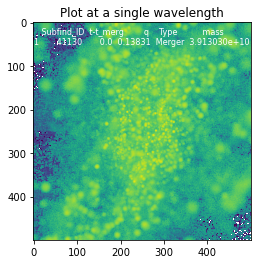

In [6]:
# Write a little subroutine to go grab information about each galaxy: q, stellar mass, t
import pandas as pd
if merger:
    table = pd.read_table('Tables/mergers_all_nodup_'+str(snap)+'_L35n2160TNG.txt')
    info = table[table['Subfind_ID']==id]
else:
    table = pd.read_table('Tables/nonmergers_snap_'+str(snap)+'_L35n2160TNG.txt')
    info = table[table['Subfind_ID']==id]
    
plt.clf()
plt.imshow(im[0].data[10,:,:], norm=matplotlib.colors.LogNorm())
plt.annotate(str(info), xy=(0,50), xycoords='data', color='white', size=8)
plt.title('Plot at a single wavelength')
plt.show()

In [7]:
# Plot all of the different viewpoints

def plot_all_angles(file):
    # file is output'+str(snap)+'_'+str(id)+'
    fig = plt.figure(figsize = (15,10))
    ax = fig.add_subplot(231)
    im_plot = pyfits.open('SKIRT_files/'+file+'/dusty_img1_total.fits')#41130
    ax.imshow(np.sum(im_plot[0].data, axis=0), norm=matplotlib.colors.LogNorm())

    ax1 = fig.add_subplot(232)
    im_plot = pyfits.open('SKIRT_files/'+file+'/dusty_img2_total.fits')#41130
    ax1.imshow(np.sum(im_plot[0].data, axis=0), norm=matplotlib.colors.LogNorm())

    ax2 = fig.add_subplot(233)
    im_plot = pyfits.open('SKIRT_files/'+file+'/dusty_img3_total.fits')#41130
    ax2.imshow(np.sum(im_plot[0].data, axis=0), norm=matplotlib.colors.LogNorm())

    ax3 = fig.add_subplot(234)
    im_plot = pyfits.open('SKIRT_files/'+file+'/dusty_img4_total.fits')#41130
    ax3.imshow(np.sum(im_plot[0].data, axis=0), norm=matplotlib.colors.LogNorm())

    ax4 = fig.add_subplot(235)
    im_plot = pyfits.open('SKIRT_files/'+file+'/dusty_img5_total.fits')#41130
    ax4.imshow(np.sum(im_plot[0].data, axis=0), norm=matplotlib.colors.LogNorm())

    ax5 = fig.add_subplot(236)
    im_plot = pyfits.open('SKIRT_files/'+file+'/dusty_img6_total.fits')#41130
    ax5.imshow(np.sum(im_plot[0].data, axis=0), norm=matplotlib.colors.LogNorm())

    plt.show()

In [18]:
def combine(wav_rest, im, z, redshift_observation, cen_x, cen_y, cut_arc, filter_id, filter_name,  brighten, bg_limiting_m,size_detector_pix_arc, l_eff, verbose):
    
    
    
    
    # Convert to Jy from MJy/sr
    Jy = im[0].data*1e6
    size = np.shape(Jy)[1]
    size_pix_arc_obs = im[0].header['CDELT1']
    kpc_arcmin_obs=Planck15.kpc_proper_per_arcmin(redshift_observation)#insert the redshift to get the kpc/arcmin scaling                      
    
    if verbose:
        plt.clf()
        plt.imshow(abs(np.sum(Jy, axis=0)),  cmap = 'magma', norm=matplotlib.colors.LogNorm())#vmin=1e2,vmax=1e6))#, 
                   #norm = matplotlib.colors.LogNorm(vmax = np.max(img_cut[idx_lambda,:,:])/2))
        #plt.scatter(size/2, size/2, color='red')
        plt.colorbar( label = 'MJy/sr')
        locs = [0,size/2,size]
        labels = [round((size/2 - x)*size_pix_arc_obs,1) for x in locs]
        labels_x = [-round((size/2 - x)*size_pix_arc_obs*(kpc_arcmin_obs.value/60),1) for x in locs]

        plt.xticks(locs,labels_x)
        plt.yticks(locs,labels)
        plt.title('Observed Broadband Image')
        plt.xlabel('kpc')
        plt.ylabel('Arcsec')
        plt.show()

        print('size of pixels at 10pMpc', size_pix_arc_obs, 'arcsec', size_pix_arc_obs*(kpc_arcmin_obs.value/60), 'kpc')

    # Figure out 
    kpc_arcsec_at_z = Planck15.kpc_proper_per_arcmin(z).value/60 #kpc/arcsec
    print('kpc/arcsec at z', kpc_arcsec_at_z)
    # Okay so we know how many kpc it is across, 
    # lets figure out how many arcsec that is at this redshift
    
    kpc_across = size*size_pix_arc_obs*(kpc_arcmin_obs.value/60)
    arc_across = kpc_across / kpc_arcsec_at_z
    size_pix_arc = arc_across / size
    
    print('size pic in arc at z', size_pix_arc)
    
    
    # Now, time to start moving the observation to higher redshift by first accounting 
    # for the physical size of the pixels at the 10 p Mpc distance
    '''
    STOP
    
    
    
    
    
    
    
    # I think I actually should get rid of steradians RIGHT AWAY
    Flux_Jy = (im[0].data*1e6) #Jy # also used to be (pixelscale_pc/1e6)**2) [to get rid of SR]
    
    
    
    
    pixelscale_kpc = size_pix_arc * (kpc_arcmin.value/60)
    print('size of a pixel in kpc', pixelscale_kpc)
    print('size of a pixel in arc', size_pix_arc)
    
    
    size_pix = int(cut_arc/size_pix_arc)
    
    
    if size_pix > np.shape(Flux_Jy)[1]/2: # this would happen if the image isn't big enough
        size_pix = int(np.shape(Flux_Jy)[1]/2)
        cut_arc = size_pix*size_pix_arc
    # so this is cutting it up to an arcsec size
    Jy_cut = Flux_Jy[:,cen_x-size_pix:cen_x+size_pix,cen_y-size_pix:cen_y+size_pix]
    

    idx_lambda = find_nearest(wav_rest, l_eff)[1]
    
    
    
    

    
    
    '''
    
    # Specific intensity (I_nu) is W/m^2/sr/Hz
    # is invariant to distance
    
    # Code from Ben
    from astropy import units as u
    from astropy.constants import c
    
    # Convert back to a surface brightness
    B_nu_rest = Jy#/size_pix_arc**2

    pixel_size = 1 * u.sr #size_pix_arc * u.arcsec # replace with output pixel size, or with 1 * u.sr if you want to keep output units as sr^{-1}

    # Add units
    B_nu_rest *= u.Jy / u.sr#(u.arcsec*u.arcsec)#**2
    wav_rest *= u.micron
    
    if verbose:
        plt.clf()
        plt.plot(wav_rest, np.sum(B_nu_rest, axis=(1,2)))
        plt.title('Is this the rest wavelength?')
        plt.axvline(x = 656.6*10**(-3))
        #plt.xlim([0.5,1.5])
        plt.show()

        print(np.shape(B_nu_rest), np.shape(wav_rest))
        print('this would be the factor you need to brighten by to get intrinsic surface brightness')
        print((1+redshift_observation)**4)
    

    
    
    
    
    '''cut_lambda = 3*(1+redshift)#3
    cut_idx_wav = find_nearest(wave_obs.value, cut_lambda)[1] # This gives you the index where you need to cut
    
    cut_wav = wave_obs[1:cut_idx_wav+1]
    cut_img_cut = I_nu_obs[:cut_idx_wav,:,:]
    
    cut_lambda = 3#*(1+redshift)#3
    cut_idx_rest = find_nearest(wav_rest[1:].value, cut_lambda)[1]
    cut_wav_rest = wav_rest[1:cut_idx_rest+1]
    cut_img_rest = B_nu_rest[:cut_idx_rest,:,:]
    
    # While you're at it just plot the f*ing SED
    plt.clf()
    plt.plot(cut_wav, np.sum(cut_img_cut, axis=(1,2)), label='Observed')
    #plt.plot(cut_wav_rest, np.sum(cut_img_rest, axis=(1,2)), label='Rest frame, pre dimmed')
    plt.title('SED + Filters')
    plt.xlabel('Wavelength, Microns')
    
    # go and grab the filter to overplot plz
    ylim = 2*np.max(np.sum(cut_img_cut.value, axis=(1,2)))
    plot_filter(filter_id, filter_name, filtercolor, ylim)
    ##index_filter = find_nearest(cut_wav, l_eff)[1]
    #plt.axvline(x=l_eff)
    plt.legend()
    plt.ylabel('Flux [MJy/sr]')
    plt.ylim([0, ylim])
    #plt.xlim([3000,10000])
    plt.xlim([0.7, 5])
    plt.show()'''
    
    #if verbose:
        #kpc_arcmin_obs=cosmo.kpc_proper_per_arcmin(redshift_observation)
        #plot_SED(redshift, wave_obs, I_nu_obs, size*size_pix_arc)
        
    
   
    
    
    '''
    plt.clf()
    plt.plot(wave_obs, np.sum(I_nu_obs, axis=(1,2))/size**2)
    plt.title('Average Spectrum for the FOV')
    plt.show()

    
    
    # First, do it all at once, summed up
    f_nu_obs_in_one_pixel = np.sum(I_nu_obs, axis=(1,2))  #* (pixel_size**2)

    

    # unit conversions, switch to f_lambda, and strip the astropy units again
    f_lambda_obs_per_area = f_nu_obs_in_one_pixel.to(u.erg/u.s/u.Hz /u.cm**2 / u.sr ).value * c.to(u.AA/u.s).value / wave_obs.to(u.AA).value**2
    #/u.arcsec**2

    # filter projection
    mags_per_area = observate.getSED(wave_obs.to(u.AA).value, f_lambda_obs_per_area, filterlist=bandlist)
    plt.clf()
    plt.plot(wave_obs, f_nu_obs_in_one_pixel)
    plt.title('Summed Spectrum for the FOV mag = '+str(mags_per_area))
    plt.show()
    '''
    
    # Okay split it up
    # Do the redshifting
    a = (1+z)
    wave_obs = wav_rest * a
    # wave_obs = wav_obs[1:]
    # Source for cosmological surface brightness dimming: 
    # https://iopscience.iop.org/article/10.1088/0004-637X/796/2/102/meta
    # B_nu is the surface brightness and I_nu is the specific intensity 
    # (which has been corrected for cosmo dimming)
    I_nu_obs = B_nu_rest / (a/(1+redshift_observation))**3# 
    
    
    '''
    # Compare this to Jacob's method - he uses 1/D_L**2
    #Flux = fnu*(1/D_L)**2*extinction*(1+z)* (pixel*pixel in pc)/(1e6)**2 * 1e6 #units are Jy
    luminosity_distance = Planck15.luminosity_distance(z).value
    print('luminosity distance', luminosity_distance, 'Mpc')
    size_pix_pc = 60.081283552314665
    # Multiply surface brightness by omega (unit solid angle) = A/D_A**2 to get flux
    # D_L = (1+z)^2 D_A
    dim_factor_Jacob = a*(10e6/luminosity_distance*1e6)**2 * (size_pix_pc**2)/(10e6)**2
    print('redshift dimming factor Jacob', dim_factor_Jacob)
    
    print('what is 1+z', a)
    '''
    
    
    if verbose:
        plt.clf()
        plt.plot(wave_obs, np.sum(I_nu_obs, axis=(1,2)))
        plt.title('Observed wavelength')
        plt.axvline(x = 656.6*10**(-3))

        plt.show()

        plt.clf()
        plt.imshow(np.sum(I_nu_obs, axis=0), norm=matplotlib.colors.LogNorm())
        plt.colorbar()
        plt.title('Dimmed SB (1+z)^4')
        plt.show()
    
    
    bandlist = observate.load_filters(filter_name)
    


    
    img_mag = np.zeros((np.shape(I_nu_obs)[1], np.shape(I_nu_obs)[2]))
    

    
    
    for i in range(np.shape(I_nu_obs)[1]):
        for j in range(np.shape(I_nu_obs)[2]):
            # the output of this is the value of the pixel in AB mags/arcsec^2
            
            # convert to flux density per pixel (or per sr if pixel_size = 1 * u.sr)
            f_nu_obs_in_one_pixel = I_nu_obs[:,i,j]  #* (pixel_size**2)


            # unit conversions, switch to f_lambda, and strip the astropy units again
            f_lambda_obs_per_area = f_nu_obs_in_one_pixel.to(u.erg/u.s/u.Hz /u.cm**2 / u.sr  ).value * c.to(u.AA/u.s).value / wave_obs.to(u.AA).value**2
            #/u.arcsec**2
            
            # filter projection
            img_mag[i,j] = observate.getSED(wave_obs.to(u.AA).value, f_lambda_obs_per_area, filterlist=bandlist)


            #img_mag[i,j] = mags_per_area
            
    
    # Redshift dimming applied now
    
    Jy_per_sr = 3631 * 10**(-0.4 * img_mag) #/ (a/(1+redshift_observation))**4

   

    # We are assuming the PSF has the same pixelscale as the JWST image for that filter
    # (Well actually it gives you a couple of extensions, one of them has the same sampling (ext 1))
    '''
    nc = webbpsf.NIRCam()
    nc.filter=filter_id
    psf = nc.calc_psf(fov_arcsec=cut_arc) # was 2 arcsec
    '''
    # From this site, a good approx of the PSF is a 0.16 FWHM (@ max)
    # https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-predicted-performance/nircam-point-spread-functions
    
    # Only works for wide filters
    dict_filter_fwhm = {'070':0.03,'090':0.034,'115':0.04,'150':0.05,'200':0.066,'277':0.091,'356':0.115,'444':0.145}
    lambda_filter = str.split(str.split(filter_id,'F')[1],'W')[0]
    fwhm = dict_filter_fwhm[lambda_filter] # in arcsec
        
    
    size_pix = size_detector_pix_arc #arcsec
    
    # Let's make the thing about 10 times as large as the FWHM
    # size = 10*0.16 = 1.6" across
    # how many pixels is this?
    factor = 10
    size_across_arc = factor*fwhm
    size_across_pix = int(size_across_arc / size_pix)
    
    x = np.linspace(0,size_across_pix - 1,size_across_pix)
    y = np.linspace(0,size_across_pix - 1,size_across_pix)
    
    def twod_gauss(x, y, mu_x, mu_y, sigma):
        # How the hell is this not a single number?
        value = np.exp(- ( (x - mu_x)**2 + (y - mu_y)**2 ) / (2 * sigma**2))
        if value < 0.001:
            value ==0
        return value
        
    
    twod = np.zeros((size_across_pix, size_across_pix))
    for i in range(len(x)):
        for j in range(len(y)):
            twod[i, j] = twod_gauss(x[i], y[j], size_across_pix/2, size_across_pix/2, (fwhm/2.54)/size_pix)
    
    if verbose:
        plt.clf()
        plt.imshow(twod)
        plt.colorbar()
        plt.show()




        print('size before rebinning', size_pix_arc)
        print('this will be size after rebinning', size_detector_pix_arc)
    factor = size_pix_arc/size_detector_pix_arc
    # you have to use the difference between the current size of pixels (in the sim image)
    # and the size of pixels on the JWST detector
    rebin = scipy.ndimage.zoom(Jy_per_sr, factor, order=0)

    
    if verbose:
        plt.clf()
        plt.imshow(rebin, cmap='magma_r')#, vmin=min_mag, vmax=max_mag)
        plt.colorbar()
        plt.title('Rebinned Jy/arcsec2')
        size = np.shape(rebin)[1]
        locs = [0,size/2,size]
        labels = [-round((size/2 - x)*size_detector_pix_arc,1) for x in locs]
        labels_y = [-round((size/2 - x)*size_detector_pix_arc*kpc_arcsec_at_z,1) for x in locs]
        plt.xticks(locs,labels)
        plt.yticks(locs,labels_y)
        plt.xlabel('Arcsec')
        plt.ylabel('kpc')
        plt.show()

    '''if verbose:
        plt.clf()
        plt.imshow(rebin, cmap='magma_r')#, vmin=min_mag, vmax=max_mag)
        plt.colorbar()
        plt.title('Rebinned Jy/arcsec2')
        size = np.shape(rebin)[1]
        locs = [0,size/2,size]
        labels = [round((size/2 - x)*size_detector_pix_arc,1) for x in locs]
        plt.xticks(locs,labels)
        plt.yticks(locs,labels)
        plt.show()'''
        
        
    
    try:
        result = (convolve(rebin, twod))# psf[1].data
    except:
        # this is an error that occurs when the psf doesn't have odd dimensions
        
        
        result = convolve(rebin, twod[1:,1:])
        
        
    
    if verbose:
        plt.clf()
        plt.imshow(result, cmap='magma_r')
        plt.colorbar()
        plt.title('Convolved and Rebinned')
        plt.show()

    # 1 sr = 4.25 x 10^10 arcsec2
    nJy = ((result*10**9)/(4.25*10**10))*size_detector_pix_arc**2
    
    

    # the last step is to add background
    nJy_bg = background_resids(bg_limiting_m, size_detector_pix_arc, l_eff, rebin, verbose)

    
    # Alternately, just add in the JADES background + bg galaxies using Guitarra
    #nJy_bg = Guitarra_bg(cut_arc, filter_id)
   
    
    AB = convert_to_AB(nJy)
    AB_bg = convert_to_AB(nJy_bg)
    if verbose:
        plt.clf()
        plt.imshow(nJy_bg)
        plt.colorbar()
        plt.title('Just background nJy '+str(filter_name))
        plt.show()



        plt.clf()
        plt.imshow(nJy)
        plt.colorbar()
        plt.title('Just image nJy '+str(filter_name))
        plt.show()

        '''plt.clf()
        plt.imshow(AB)
        plt.colorbar()
        plt.title('Just image AB '+str(filter_name))
        plt.show()'''

        plt.clf()
        plt.hist(nJy_bg.flatten(), bins=100)
        plt.xlabel('')
        plt.show()
    
    plt.clf()
    plt.imshow(abs(nJy+nJy_bg), norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.title('nJy image '+str(filter_name))
    plt.show()
    
    '''plt.clf()
    plt.imshow(abs(nJy+nJy_bg), norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.title('nJy image log '+str(filter_name))
    plt.show()'''
    
    
    
    
    # output is image with added bg, then size of the pixels in arc, then size of the pixels in kpc 
    return nJy+nJy_bg, size_detector_pix_arc, size_detector_pix_arc*kpc_arcsec_at_z



def plot_filters(id_list, filtercolor, ymax_data):
    
    
    for j in range(len(id_list)):
        filtertxt = np.loadtxt('greg_JWST_filters/nircam_'+str(id_list[j]))

        # use the max of the data

        plt.fill_between(filtertxt[:,0]/1e4, 0, filtertxt[:,1]*(ymax_data/4), color=filtercolor[j], alpha=0.5)
        plt.plot(filtertxt[:,0]/1e4, filtertxt[:,1]*(ymax_data/4), color=filtercolor[j])
def plot_SED(redshift, wave_obs, I_nu_obs,arcsec_side ):
    cut_lambda = 3*(1+redshift)#3
    cut_idx_wav = find_nearest(wave_obs.value, cut_lambda)[1] # This gives you the index where you need to cut
    
    cut_wav = wave_obs[1:cut_idx_wav+1]
    cut_img_cut = I_nu_obs[:cut_idx_wav,:,:]
    
    # While you're at it just plot the f*ing SED
    plt.clf()
    fig = plt.figure(figsize = (8,5))
    
    #plt.plot(cut_wav_rest, np.sum(cut_img_rest, axis=(1,2)), label='Rest frame, pre dimmed')
    #plt.title('SED + Filters')
    plt.xlabel(r'Observed Wavelength ($\mu$m)')
    
    # go and grab the filter to overplot plz
    ylim = 2*np.max(np.sum(cut_img_cut.value, axis=(1,2)))
    
    filter_list = ['F070W','F090W','F115W','F150W','F200W','F277W','F356W','F410M','F444W']
    filtercolor = ['#0D69AB', '#6E99C9','#9FC3E9','#6874AC',
                   '#342B75','#6B327B','#923978','#DC9095','#E4ADC8']
    plot_filters(filter_list, filtercolor, ylim)
    ##index_filter = find_nearest(cut_wav, l_eff)[1]
    #plt.axvline(x=l_eff)
    #plt.legend()
    plt.ylabel('Integrated Surface Brightness [MJy/sr]')
    plt.step(cut_wav, np.sum(cut_img_cut, axis=(1,2)),  color='black')
    plt.ylim([0.01e10, ylim*0.7])
    #plt.annotate('Star-Forming Galaxy at $z = $'+str(redshift), xy=(0.02,0.9), xycoords='axes fraction', color='black')
    #plt.xlim([3000,10000])
    plt.xlim([0.7, 5])
    plt.show()
    
    
    
    plt.clf()
    fig = plt.figure(figsize = (8,5))
    #plot_filters(filter_list, filtercolor, ylim)
    plt.ylabel('Integrated Flux [nJy]')
    flux = ((((np.sum(cut_img_cut, axis=(1,2)))/4.25e10)*arcsec_side**2)/1e6)# in Jy
    
    ylim = 2*np.max(flux)
    plot_filters(filter_list, filtercolor, ylim)
    plt.step(cut_wav, 1e9*flux,  color='black')
    #plt.ylim([0.01e10, ylim*0.7])
    #plt.annotate('Star-Forming Galaxy at $z = $'+str(redshift), xy=(0.02,0.9), xycoords='axes fraction', color='black')
    #plt.xlim([3000,10000])
    plt.xlim([0.7, 5])
    plt.show()
    
    
    # Now convert to AB mags:
    plt.clf()
    fig = plt.figure(figsize = (8,5))
    #plot_filters(filter_list, filtercolor, ylim)
    plt.ylabel('Integrated Flux [AB mag]')
    
    AB = -2.5 * np.log10(np.array(flux.value) / 3631)
    
    ylim = 2*np.max(AB)
    plot_filters(filter_list, filtercolor, ylim)
    plt.step(cut_wav, AB,  color='black')
    plt.ylim([30,20])
    # compare to Christina's paper: https://iopscience.iop.org/article/10.3847/1538-4365/aabcbb/pdf
    
    #plt.annotate('Star-Forming Galaxy at $z = $'+str(redshift), xy=(0.02,0.9), xycoords='axes fraction', color='black')
    #plt.xlim([3000,10000])
    plt.xlim([0.7, 5])
    plt.show()
    
    #plt.savefig('mock_panels/SED.png', dpi=500)
    
    
def background_resids(bg_limiting_magnitude,size_detector_pix_arc, l_eff, rebin, verbose):
    # This section takes the limiting magnitude and converts to a surface brightness 
    # in units of 
    
    # Super useful ref from Paul Green: https://hea-www.harvard.edu/~pgreen/figs/Conversions.pdf
    
    bg_limiting_nJy = (3631*10**(bg_limiting_magnitude/(-2.5)))*1e9

    print('bg limit Jy', bg_limiting_nJy)

    

    bg_sigma = 0.2*bg_limiting_nJy
    
    
    

    background = np.zeros(np.shape(rebin))
    mu, sigma = 0, bg_sigma # mean and standard deviation

    for i in range(np.shape(background)[0]):
        for j in range(np.shape(background)[1]):
            s = np.random.normal(mu, sigma, 1)
            background[i,j] = s

    
    '''if verbose:
        plt.clf()
        plt.imshow(background, cmap='magma_r')
        plt.colorbar(label='erg/s/cm2/A')
        plt.title('Background')
        plt.show()

        plt.clf()
        plt.imshow(rebin+background, cmap='magma_r')
        plt.colorbar(label='erg/s/cm2/A')
        plt.title('Background + image')
        plt.show()
        
        
        # Now convert back into Jy and then AB mags
        # convert from AB mags to Janskies
        # Janskies = 10**(img_mag/(-2.5))*3631# the AB mag zeropt is defined to be 3631 Jy
    
        # Now convert back to erg/s/cm2/A
        # per_A = 2.99792458E-05 * Janskies / l_eff**2# l_eff is the effective wavelength

        Jy = l_eff**2*(rebin+background)/2.99792458E-05
        
        xcen = 45
        ycen = 35
        plt.clf()
        plt.imshow(Jy, cmap = 'magma_r')
        plt.colorbar(label='Jy/arcsec**2')
        plt.scatter(xcen, ycen, color='black', marker='x')
        plt.show()
        
        plt.clf()
        plt.imshow(Jy[xcen-3:xcen+4,ycen-3:ycen+4], cmap = 'magma_r')
        plt.colorbar(label='Jy/arcsec**2')
        #plt.scatter(45,35, color='black', marker='x')
        plt.show()
        
        ap_sum_Jy = np.sum(Jy[xcen-3:xcen+4,ycen-3:ycen+4])
        ap_avg_Jy = np.mean(Jy[xcen-3:xcen+4,ycen-3:ycen+4])
        print('Sum Jy of aperture', ap_sum_Jy)
        print('Avg Jy of aperture', ap_avg_Jy)
        
        
        img_mag = -2.5*np.log10(abs(Jy/3631))
        bg_mag = -2.5*np.log10(abs(l_eff**2*(background)/2.99792458E-05)/3631)
        
        print('mag of this aperture', -2.5*np.log10(ap_sum_Jy/3631))
        print('mag of this aperture', -2.5*np.log10(ap_avg_Jy/3631))
        
        plt.clf()
        plt.imshow(bg_mag, cmap = 'magma_r')
        plt.colorbar(label='mag/arcsec**2')
        plt.title('Background in mag/arcsec**2')
        plt.show()
        
        plt.clf()
        plt.imshow(img_mag, cmap = 'magma_r')
        plt.colorbar(label='mag/arcsec**2')
        plt.show()
        
        # Now calculate just the average bg mag - 
        Jy_bg_mean = l_eff**2*(bg_limiting_flambda)/2.99792458E-05
        print('mag of bg sum',-2.5*np.log10(Jy_bg_mean*int(np.sqrt(0.2/size_detector_pix_arc**2))/3631))
        print('mag of bg mean',-2.5*np.log10(Jy_bg_mean/3631))'''
        
        
    return background
def convert_to_nJy(convolved, pix_arc, wavelength):
    #input is a surface brightness units are [erg/s/cm2/A/arcsec2]
    
    erg_s_cm2_A = convolved*pix_arc**2 # convert from a surface brightness to a specific flux?
    
    # Then from here ( https://hea-www.harvard.edu/~pgreen/figs/Conversions.pdf )
    erg_s_cm2_Hz = erg_s_cm2_A*wavelength**2*3.34e-19
    Jy = erg_s_cm2_Hz/1e-23
    return Jy*1e9

def convert_to_AB(nJy):
    # Convert to AB mags :)
    #bg_limiting_nJy = (3631*10**(bg_limiting_magnitude/(-2.5)))*1e9
    
    return -2.5*np.log10((nJy/1e9)/3631)



redshift 1
output50_41130
snap 50 id 41130.0 redshift 1
info    Subfind_ID  t-t_merg        q    Type          mass
1       41130       0.0  0.13831  Merger  3.913030e+10


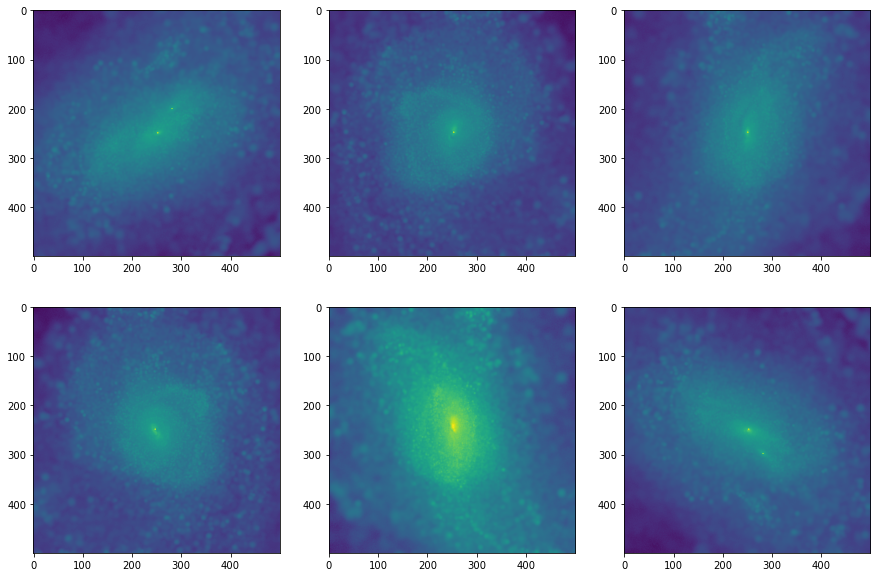

kpc/arcsec at z 8.231906774990978
size pic in arc at z 0.007298586487257748


/Users/rebeccanevin/opt/anaconda3/lib/python3.7/site-packages/sedpy/observate.py:412: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(counts / self.ab_zero_counts)


In [ ]:
# Run multiple different galaxies through and plot them

verbose=False

brighten = 1


cut_arc = 100#12.6

# I'm just goint to center on the snapshot for now
cenx =int(np.shape(im[0].data)[1]/2)
ceny = int(np.shape(im[0].data)[2]/2)

print('redshift', redshift)


cut_arc = 200#







# Run through multiple galaxies

holder_images = np.zeros((len(os.listdir('SKIRT_files/')), np.shape(im[0].data)[2], np.shape(im[0].data)[2]))
info_list = []

img_f444w_list = []
img_f356w_list = []
img_f277w_list = []
img_f200w_list = []
img_f115w_list = []
img_f090w_list = []

pix_f444w_arc_list = []
pix_f444w_kpc_list = []

pix_f356w_arc_list = []
pix_f356w_kpc_list = []

pix_f277w_arc_list = []
pix_f277w_kpc_list = []

pix_f200w_arc_list = []
pix_f200w_kpc_list = []

pix_f115w_arc_list = []
pix_f115w_kpc_list = []

pix_f090w_arc_list = []
pix_f090w_kpc_list = []

redshift_list = []

counter = 0
for file in os.listdir('SKIRT_files/'):
    print(file)
    # Okay figure out the id and the snap and the redshift
    out_1 = file.split('_')[0]
    snap = int(float(out_1.split('output')[1]))
    id = float(file.split('_')[1])
    redshift = redshift_snap[snap]
    print('snap', snap, 'id', id, 'redshift', redshift)
    
    # Get info about this galaxy
    if merger:
        table = pd.read_table('Tables/mergers_all_nodup_'+str(snap)+'_L35n2160TNG.txt')
        info = table[table['Subfind_ID']==id]
    else:
        table = pd.read_table('Tables/nonmergers_snap_'+str(snap)+'_L35n2160TNG.txt')
        info = table[table['Subfind_ID']==id]
    print('info', info)
    info_list.append(info)
    try:
        plot_all_angles(file)
    except:# FileNotFoundError:
        print('doesnt have the .fits files yet')
        continue
    
    im = pyfits.open('SKIRT_files/'+file+'/dusty_img1_total.fits')#41130
    hdr = im[0].header

    FOV_arc = hdr['CDELT1']*np.shape(im[0].data)[1]
    

    #print(repr(hdr))
    wav_array = im[1].data
    wav = []
    for j in range(len(wav_array)):
        wav.append(wav_array[j][0])
    wav = np.array(wav)

    wav_rest = wav / (1+redshift_observation)
    
    
    filter_id = 'F444W'
    size_detector_pix_arc = 0.031
    l_eff = 0.814#e4
    # need to convert from microns to A
    bg_limiting_sb_flambda = 7.57e-18 # this is flambda/arcsec^2
    bg_limiting_mag = 29.8#29.8# from the CEERs white paper 
    filter_name = ['acs_wfc_f814w']
    
    mock_f444w, pix_arc, pix_kpc = combine(wav_rest, im, redshift, redshift_observation, cenx, ceny, cut_arc, filter_id, filter_name, 
                     brighten, bg_limiting_mag,size_detector_pix_arc, l_eff, verbose)
    img_f444w_list.append(mock_f444w)
    pix_f444w_arc_list.append(pix_arc)
    pix_f444w_kpc_list.append(pix_kpc)
    
    
    
    filter_id = 'F444W'
    size_detector_pix_arc = 0.063
    l_eff = 4.44#e4
    # need to convert from microns to A
    bg_limiting_sb_flambda = 7.57e-18 # this is flambda/arcsec^2
    bg_limiting_mag = 29.8#29.8# from the CEERs white paper 
    filter_name = ['jwst_f444w']
    
    mock_f444w, pix_arc, pix_kpc = combine(wav_rest, im, redshift, redshift_observation, cenx, ceny, cut_arc, filter_id, filter_name, 
                     brighten, bg_limiting_mag,size_detector_pix_arc, l_eff, verbose)
    img_f444w_list.append(mock_f444w)
    pix_f444w_arc_list.append(pix_arc)
    pix_f444w_kpc_list.append(pix_kpc)
    
    
    
    filter_id = 'F356W'
    size_detector_pix_arc = 0.063
    l_eff = 3.56#e4
    bg_limiting_mag = 30.1# from the CEERs white paper 
    filter_name = ['jwst_f356w']
    mock_f356w, pix_arc, pix_kpc = combine(wav_rest, im, redshift, redshift_observation, cenx, ceny, cut_arc, filter_id, filter_name, 
                         brighten, bg_limiting_mag,size_detector_pix_arc, l_eff, verbose)
    img_f356w_list.append(mock_f356w)
    pix_f356w_arc_list.append(pix_arc)
    pix_f356w_kpc_list.append(pix_kpc)
    
    filter_id = 'F277W'
    size_detector_pix_arc = 0.063
    l_eff = 2.77#e4
    bg_limiting_mag = 30.2# from the CEERs white paper 
    filter_name = ['jwst_f277w']
    mock_f277w, pix_arc, pix_kpc = combine(wav_rest, im, redshift, redshift_observation, cenx, ceny, cut_arc, filter_id, filter_name, 
                         brighten, bg_limiting_mag,size_detector_pix_arc, l_eff, verbose)
    
    img_f277w_list.append(mock_f277w)
    pix_f277w_arc_list.append(pix_arc)
    pix_f277w_kpc_list.append(pix_kpc)
    
    filter_id = 'F200W'
    size_detector_pix_arc = 0.031#0.031
    l_eff = 2.00#e4
    bg_limiting_mag = 30.6#29.7#30.6
    filter_name = ['jwst_f200w']
    mock_f200w, pix_arc, pix_kpc = combine(wav_rest, im, redshift, redshift_observation, cenx, ceny, cut_arc, filter_id, filter_name, 
                         brighten, bg_limiting_mag,size_detector_pix_arc, l_eff, verbose)
    img_f200w_list.append(mock_f200w)
    pix_f200w_arc_list.append(pix_arc)
    pix_f200w_kpc_list.append(pix_kpc)
    
    filter_id = 'F115W'
    l_eff = 1.15#e4#70e4
    size_detector_pix_arc = 0.031#0.063#0.031
    bg_limiting_mag = 30.5#30.5#29.8#28.7 Unclear if this is /arcsec^2 or not
    filter_name = ['jwst_f115w']
    mock_f115w, pix_arc, pix_kpc = combine(wav_rest, im, redshift, redshift_observation, cenx, ceny, cut_arc, filter_id, filter_name, 
                         brighten, bg_limiting_mag,size_detector_pix_arc, l_eff, verbose)
    img_f115w_list.append(mock_f115w)
    pix_f115w_arc_list.append(pix_arc)
    pix_f115w_kpc_list.append(pix_kpc)
    
    filter_id = 'F090W'
    size_detector_pix_arc = 0.031#0.031
    l_eff = 0.9#e4
    bg_limiting_mag = 30.2
    filter_name = ['jwst_f090w']
    mock_f090w, pix_arc, pix_kpc = combine(wav_rest, im, redshift, redshift_observation, cenx, ceny, cut_arc, filter_id, filter_name, 
                         brighten, bg_limiting_mag,size_detector_pix_arc, l_eff, verbose)
    img_f090w_list.append(mock_f090w)
    pix_f090w_arc_list.append(pix_arc)
    pix_f090w_kpc_list.append(pix_kpc)
    
    redshift_list.append(redshift)
    
    counter+=1
    

STOP









'''filter_id = 'F090W'
size_detector_pix_arc = 0.031#0.031
l_eff = 0.9#e4
bg_limiting_mag = 30.2
filter_name = ['jwst_f090w']
mock_f090w = combine(wav, im5, redshift, cenx, ceny, cut_arc, filter_id, filter_name, 
                     brighten, bg_limiting_mag,
              size_detector_pix_arc, l_eff, verbose)'''









0.0
0.0
0.0
0.0
0.0


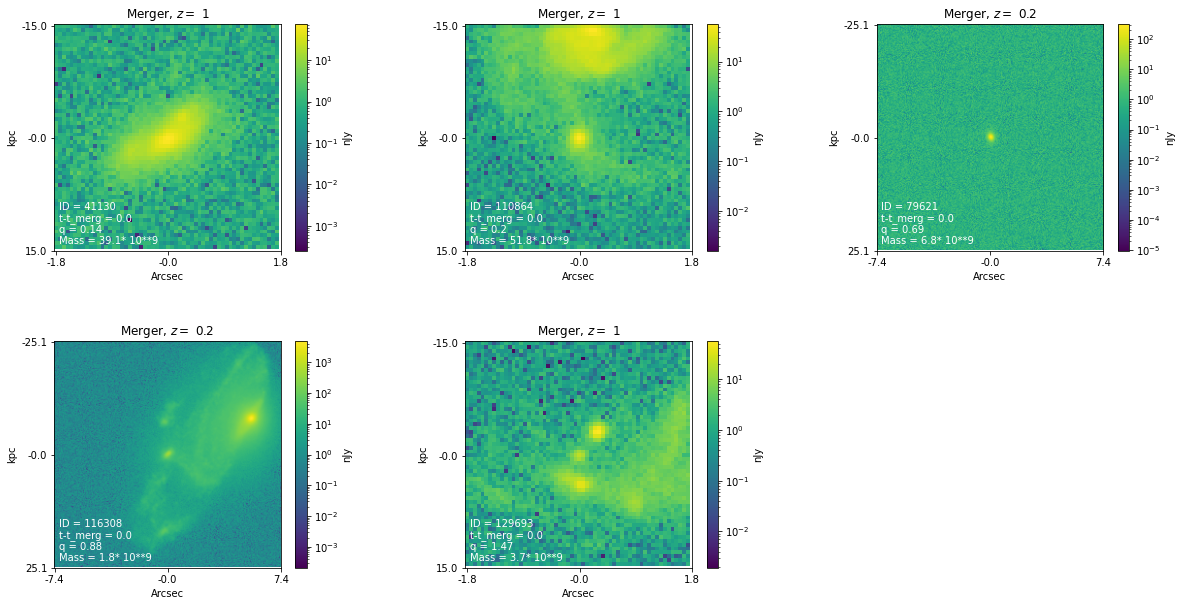

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


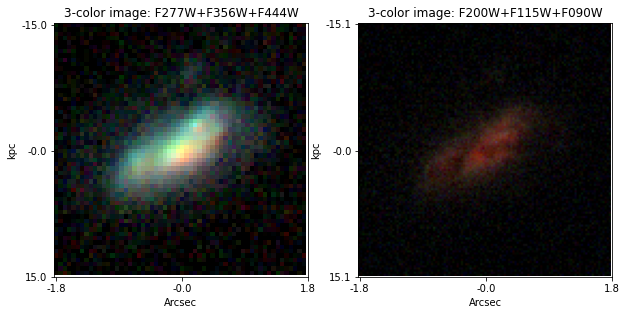

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


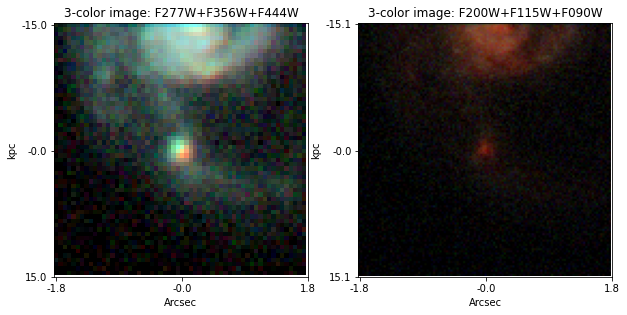

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


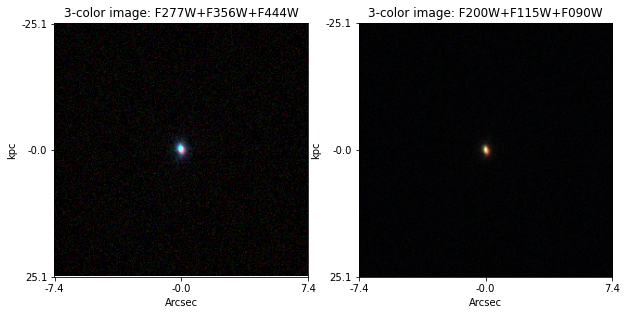

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


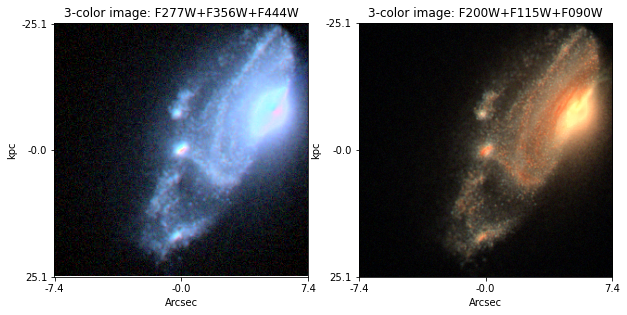

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


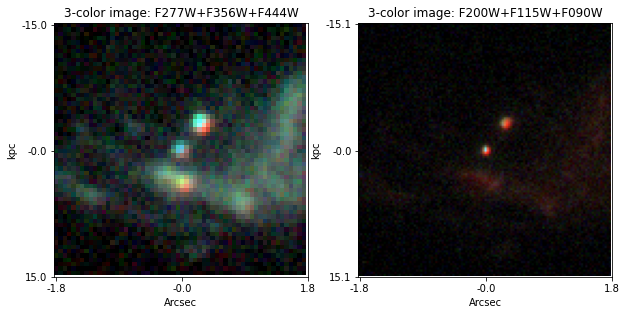

NameError: name 'STOP' is not defined

In [180]:
# Try to do the lupton asinh: https://docs.astropy.org/en/stable/_modules/astropy/visualization/lupton_rgb.html#make_lupton_rgb
minimum=0
maximum = 100
stretch=5
Q=3




def big_F(x, beta):
    return math.asinh(x / beta)

def little_f(x, m, M, beta):
    array = np.zeros((np.shape(x)))
    for i in range(np.shape(x)[0]):
        for j in range(np.shape(x)[1]):
            
            if x[i,j] < m:
                array[i,j] = 0
            if x[i,j] < M and x[i,j] > m:
                array[i,j] = big_F(x[i,j] - m, beta)/big_F(M - m, beta)
            if x[i,j] > M:
                array[i,j] = 1
                
    return array

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(len(img_f444w_list)):
    ax = fig.add_subplot(2, 3, i+1)
    im = ax.imshow(abs(img_f444w_list[i]), norm=matplotlib.colors.LogNorm())
    plt.colorbar(im, fraction = 0.046, label='nJy')
    print(info_list[i]['t-t_merg'].values[0])
    ax.annotate('ID = '+str(info_list[i]['Subfind_ID'].values[0]), xy=(0.02,0.18), xycoords='axes fraction', color='white')
    ax.annotate('t-t_merg = '+str(info_list[i]['t-t_merg'].values[0]), xy=(0.02,0.13), xycoords='axes fraction', color='white')
    ax.annotate('q = '+str(round(info_list[i]['q'].values[0],2)), xy=(0.02,0.08), xycoords='axes fraction', color='white')
    ax.annotate('Mass = '+str(round(info_list[i]['mass'].values[0]/10**9,1))+'* 10**9', xy=(0.02,0.03), xycoords='axes fraction', color='white')
    
    ax.set_title(str(info_list[i]['Type'].values[0])+r', $z =$ '+str(redshift_list[i]))
    
    size = np.shape(img_f444w_list[i])[1]
    locs = [0,size/2,size]
    labels = [-round((size/2 - x)*pix_f444w_arc_list[i],1) for x in locs]
    labels_y = [-round((size/2 - x)*pix_f444w_kpc_list[i],1) for x in locs]
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks(locs)
    ax.set_yticklabels(labels_y)
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('kpc')
    
plt.show()

for i in range(len(img_f444w_list)):
    
    minimum=0
    maximum = 100
    stretch=5
    Q=3
    
    r = img_f444w_list[i]#/np.max(img_f444w_list[0])
    g = img_f356w_list[i]#/np.max(img_f356w_list[0])
    b = img_f277w_list[i]#/np.max(img_f277w_list[0])
    I = (r+g+b)/3#I { (r  g  b)/3



    R = r*little_f(I, minimum, maximum, Q)/I
    G = g*little_f(I, minimum, maximum, Q)/I
    B = b*little_f(I, minimum, maximum, Q)/I



    rgb = np.dstack((R,G,B))
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(121)
    ax.imshow(rgb)
    size = np.shape(img_f444w_list[i])[1]
    locs = [0,size/2,size]
    labels = [-round((size/2 - x)*pix_f444w_arc_list[i],1) for x in locs]
    labels_y = [-round((size/2 - x)*pix_f444w_kpc_list[i],1) for x in locs]
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks(locs)
    ax.set_yticklabels(labels_y)
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('kpc')
    ax.set_title('3-color image: F277W+F356W+F444W')
    
    '''
    minimum=0
    maximum = 10
    stretch=10
    Q=10
    '''
    r = img_f200w_list[i]#/np.max(img_f444w_list[0])
    g = img_f115w_list[i]#/np.max(img_f356w_list[0])
    b = img_f090w_list[i]#/np.max(img_f277w_list[0])
    I = (r+g+b)/3#I { (r  g  b)/3



    R = r*little_f(I, minimum, maximum, Q)/I
    G = g*little_f(I, minimum, maximum, Q)/I
    B = b*little_f(I, minimum, maximum, Q)/I



    rgb = np.dstack((R,G,B))
    ax1 = fig.add_subplot(122)
    ax1.imshow(rgb)
    size = np.shape(img_f200w_list[i])[1]
    locs = [0,size/2,size]
    labels = [-round((size/2 - x)*pix_f200w_arc_list[i],1) for x in locs]
    labels_y = [-round((size/2 - x)*pix_f200w_kpc_list[i],1) for x in locs]
    ax1.set_xticks(locs)
    ax1.set_xticklabels(labels)
    ax1.set_yticks(locs)
    ax1.set_yticklabels(labels_y)
    ax1.set_xlabel('Arcsec')
    ax1.set_ylabel('kpc')
    ax1.set_title('3-color image: F200W+F115W+F090W')
    plt.show()

STOP
asinhMap = math.asinh(Q*(np.array(I) - minimum)/stretch)/Q
plt.imshow(asinhMap)
plt.show()
#asinhMap = AsinhMapping(minimum, stretch, Q)
#rgb = asinhMap.make_rgb_image(r, g, b) # this is a dstack


plt.imshow(img)#, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()
STOP

img.save('myimg.jpeg')

# Also make multi-color images:
import astropy
print(astropy.__version__)
#from astropy.visualization import SqrtStretch
#from astropy.visualization import ZScaleInterval
#from astropy import make_lupton_rgb
from astropy.visualization import make_lupton_rgb
#image_r = 10**(-0.4*(fits.getdata(_imgName.format('i'))-22.5))
#image_g = 10**(-0.4*(fits.getdata(_imgName.format('r'))-22.5))
#image_b = 10**(-0.4*(fits.getdata(_imgName.format('g'))-22.5))
image_r = img_f444w_list[0]
image_g = img_f356w_list[0]
image_b = img_f277w_list[0]

# scale by the blue image
norm = np.nanpercentile(image_b,99)
image_r/=norm
image_g/=norm
image_b/=norm




#make_lupton_rgb
from astropy.visualization import make_lupton_rgb
image = make_lupton_rgb(image_r, image_g, image_b, Q=10,stretch=0.5,minimum=0)
plt.imshow(image,aspect='auto')
plt.show()


STOP

    
plt.clf()
plt.imshow(im[0].data[10,:,:], norm=matplotlib.colors.LogNorm())
plt.annotate(str(info), xy=(0,50), xycoords='data', color='white', size=8)
plt.title('Plot at a single wavelength')
plt.show()

In [135]:
import abc
import numpy as np

from astropy.transform import BaseTransform


__all__ = ['BaseInterval', 'ManualInterval', 'MinMaxInterval',
           'AsymmetricPercentileInterval', 'PercentileInterval',
           'ZScaleInterval']


class BaseInterval(BaseTransform):
    """
    Base class for the interval classes, which, when called with an
    array of values, return an interval computed following different
    algorithms.
    """

    def get_limits(self, values):
        """
        Return the minimum and maximum value in the interval based on
        the values provided.

        Parameters
        ----------
        values : ndarray
            The image values.

        Returns
        -------
        vmin, vmax : float
            The mininium and maximum image value in the interval.
        """

        raise NotImplementedError('Needs to be implemented in a subclass.')


    def __call__(self, values, clip=True, out=None):
        """
        Transform values using this interval.

        Parameters
        ----------
        values : array-like
            The input values.
        clip : bool, optional
            If `True` (default), values outside the [0:1] range are
            clipped to the [0:1] range.
        out : ndarray, optional
            If specified, the output values will be placed in this array
            (typically used for in-place calculations).

        Returns
        -------
        result : ndarray
            The transformed values.
        """

        vmin, vmax = self.get_limits(values)

        if out is None:
            values = np.subtract(values, float(vmin))
        else:
            if out.dtype.kind != 'f':
                raise TypeError('Can only do in-place scaling for '
                                'floating-point arrays')
            values = np.subtract(values, float(vmin), out=out)

        if (vmax - vmin) != 0:
            np.true_divide(values, vmax - vmin, out=values)

        if clip:
            np.clip(values, 0., 1., out=values)

        return values



class ManualInterval(BaseInterval):
    """
    Interval based on user-specified values.

    Parameters
    ----------
    vmin : float, optional
        The minimum value in the scaling.  Defaults to the image
        minimum (ignoring NaNs)
    vmax : float, optional
        The maximum value in the scaling.  Defaults to the image
        maximum (ignoring NaNs)
    """

    def __init__(self, vmin=None, vmax=None):
        self.vmin = vmin
        self.vmax = vmax

    def get_limits(self, values):
        # Make sure values is a Numpy array
        values = np.asarray(values).ravel()

        # Filter out invalid values (inf, nan)
        values = values[np.isfinite(values)]

        vmin = np.min(values) if self.vmin is None else self.vmin
        vmax = np.max(values) if self.vmax is None else self.vmax
        return vmin, vmax



class MinMaxInterval(BaseInterval):
    """
    Interval based on the minimum and maximum values in the data.
    """

    def get_limits(self, values):
        # Make sure values is a Numpy array
        values = np.asarray(values).ravel()

        # Filter out invalid values (inf, nan)
        values = values[np.isfinite(values)]

        return np.min(values), np.max(values)



class AsymmetricPercentileInterval(BaseInterval):
    """
    Interval based on a keeping a specified fraction of pixels (can be
    asymmetric).

    Parameters
    ----------
    lower_percentile : float
        The lower percentile below which to ignore pixels.
    upper_percentile : float
        The upper percentile above which to ignore pixels.
    n_samples : int, optional
        Maximum number of values to use. If this is specified, and there
        are more values in the dataset as this, then values are randomly
        sampled from the array (with replacement).
    """

    def __init__(self, lower_percentile, upper_percentile, n_samples=None):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.n_samples = n_samples

    def get_limits(self, values):
        # Make sure values is a Numpy array
        values = np.asarray(values).ravel()

        # If needed, limit the number of samples. We sample with replacement
        # since this is much faster.
        if self.n_samples is not None and values.size > self.n_samples:
            values = np.random.choice(values, self.n_samples)

        # Filter out invalid values (inf, nan)
        values = values[np.isfinite(values)]

        # Determine values at percentiles
        vmin, vmax = np.percentile(values, (self.lower_percentile,
                                            self.upper_percentile))

        return vmin, vmax



class PercentileInterval(AsymmetricPercentileInterval):
    """
    Interval based on a keeping a specified fraction of pixels.

    Parameters
    ----------
    percentile : float
        The fraction of pixels to keep. The same fraction of pixels is
        eliminated from both ends.
    n_samples : int, optional
        Maximum number of values to use. If this is specified, and there
        are more values in the dataset as this, then values are randomly
        sampled from the array (with replacement).
    """

    def __init__(self, percentile, n_samples=None):
        lower_percentile = (100 - percentile) * 0.5
        upper_percentile = 100 - lower_percentile
        super().__init__(
            lower_percentile, upper_percentile, n_samples=n_samples)



class ZScaleInterval(BaseInterval):
    """
    Interval based on IRAF's zscale.

    https://iraf.net/forum/viewtopic.php?showtopic=134139

    Original implementation:
    https://github.com/spacetelescope/stsci.numdisplay/blob/master/lib/stsci/numdisplay/zscale.py

    Licensed under a 3-clause BSD style license (see AURA_LICENSE.rst).

    Parameters
    ----------
    nsamples : int, optional
        The number of points in the array to sample for determining
        scaling factors.  Defaults to 1000.
    contrast : float, optional
        The scaling factor (between 0 and 1) for determining the minimum
        and maximum value.  Larger values increase the difference
        between the minimum and maximum values used for display.
        Defaults to 0.25.
    max_reject : float, optional
        If more than ``max_reject * npixels`` pixels are rejected, then
        the returned values are the minimum and maximum of the data.
        Defaults to 0.5.
    min_npixels : int, optional
        If there are less than ``min_npixels`` pixels remaining after
        the pixel rejection, then the returned values are the minimum
        and maximum of the data.  Defaults to 5.
    krej : float, optional
        The number of sigma used for the rejection. Defaults to 2.5.
    max_iterations : int, optional
        The maximum number of iterations for the rejection. Defaults to
        5.
    """

    def __init__(self, nsamples=1000, contrast=0.25, max_reject=0.5,
                 min_npixels=5, krej=2.5, max_iterations=5):
        self.nsamples = nsamples
        self.contrast = contrast
        self.max_reject = max_reject
        self.min_npixels = min_npixels
        self.krej = krej
        self.max_iterations = max_iterations

    def get_limits(self, values):
        # Sample the image
        values = np.asarray(values)
        values = values[np.isfinite(values)]
        stride = int(max(1.0, values.size / self.nsamples))
        samples = values[::stride][:self.nsamples]
        samples.sort()

        npix = len(samples)
        vmin = samples[0]
        vmax = samples[-1]

        # Fit a line to the sorted array of samples
        minpix = max(self.min_npixels, int(npix * self.max_reject))
        x = np.arange(npix)
        ngoodpix = npix
        last_ngoodpix = npix + 1

        # Bad pixels mask used in k-sigma clipping
        badpix = np.zeros(npix, dtype=bool)

        # Kernel used to dilate the bad pixels mask
        ngrow = max(1, int(npix * 0.01))
        kernel = np.ones(ngrow, dtype=bool)

        for _ in range(self.max_iterations):
            if ngoodpix >= last_ngoodpix or ngoodpix < minpix:
                break

            fit = np.polyfit(x, samples, deg=1, w=(~badpix).astype(int))
            fitted = np.poly1d(fit)(x)

            # Subtract fitted line from the data array
            flat = samples - fitted

            # Compute the k-sigma rejection threshold
            threshold = self.krej * flat[~badpix].std()

            # Detect and reject pixels further than k*sigma from the
            # fitted line
            badpix[(flat < - threshold) | (flat > threshold)] = True

            # Convolve with a kernel of length ngrow
            badpix = np.convolve(badpix, kernel, mode='same')

            last_ngoodpix = ngoodpix
            ngoodpix = np.sum(~badpix)

        if ngoodpix >= minpix:
            slope, _ = fit

            if self.contrast > 0:
                slope = slope / self.contrast
            center_pixel = (npix - 1) // 2
            median = np.median(samples)
            vmin = max(vmin, median - (center_pixel - 1) * slope)
            vmax = min(vmax, median + (npix - center_pixel) * slope)

        return vmin, vmax

# Licensed under a 3-clause BSD style license - see LICENSE.rst
"""
Combine 3 images to produce a properly-scaled RGB image following Lupton et al. (2004).

The three images must be aligned and have the same pixel scale and size.

For details, see : https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L
"""

import numpy as np
from . import ZScaleInterval


__all__ = ['make_lupton_rgb']


def compute_intensity(image_r, image_g=None, image_b=None):
    """
    Return a naive total intensity from the red, blue, and green intensities.

    Parameters
    ----------
    image_r : ndarray
        Intensity of image to be mapped to red; or total intensity if ``image_g``
        and ``image_b`` are None.
    image_g : ndarray, optional
        Intensity of image to be mapped to green.
    image_b : ndarray, optional
        Intensity of image to be mapped to blue.

    Returns
    -------
    intensity : ndarray
        Total intensity from the red, blue and green intensities, or ``image_r``
        if green and blue images are not provided.
    """
    if image_g is None or image_b is None:
        if not (image_g is None and image_b is None):
            raise ValueError("please specify either a single image "
                             "or red, green, and blue images.")
        return image_r

    intensity = (image_r + image_g + image_b)/3.0

    # Repack into whatever type was passed to us
    return np.asarray(intensity, dtype=image_r.dtype)


class Mapping:
    """
    Baseclass to map red, blue, green intensities into uint8 values.

    Parameters
    ----------
    minimum : float or sequence(3)
        Intensity that should be mapped to black (a scalar or array for R, G, B).
    image : ndarray, optional
        An image used to calculate some parameters of some mappings.
    """

    def __init__(self, minimum=None, image=None):
        self._uint8Max = float(np.iinfo(np.uint8).max)

        try:
            len(minimum)
        except TypeError:
            minimum = 3*[minimum]
        if len(minimum) != 3:
            raise ValueError("please provide 1 or 3 values for minimum.")

        self.minimum = minimum
        self._image = np.asarray(image)

    def make_rgb_image(self, image_r, image_g, image_b):
        """
        Convert 3 arrays, image_r, image_g, and image_b into an 8-bit RGB image.

        Parameters
        ----------
        image_r : ndarray
            Image to map to red.
        image_g : ndarray
            Image to map to green.
        image_b : ndarray
            Image to map to blue.

        Returns
        -------
        RGBimage : ndarray
            RGB (integer, 8-bits per channel) color image as an NxNx3 numpy array.
        """
        image_r = np.asarray(image_r)
        image_g = np.asarray(image_g)
        image_b = np.asarray(image_b)

        if (image_r.shape != image_g.shape) or (image_g.shape != image_b.shape):
            msg = "The image shapes must match. r: {}, g: {} b: {}"
            raise ValueError(msg.format(image_r.shape, image_g.shape, image_b.shape))

        return np.dstack(self._convert_images_to_uint8(image_r, image_g, image_b)).astype(np.uint8)

    def intensity(self, image_r, image_g, image_b):
        """
        Return the total intensity from the red, blue, and green intensities.
        This is a naive computation, and may be overridden by subclasses.

        Parameters
        ----------
        image_r : ndarray
            Intensity of image to be mapped to red; or total intensity if
            ``image_g`` and ``image_b`` are None.
        image_g : ndarray, optional
            Intensity of image to be mapped to green.
        image_b : ndarray, optional
            Intensity of image to be mapped to blue.

        Returns
        -------
        intensity : ndarray
            Total intensity from the red, blue and green intensities, or
            ``image_r`` if green and blue images are not provided.
        """
        return compute_intensity(image_r, image_g, image_b)

    def map_intensity_to_uint8(self, I):
        """
        Return an array which, when multiplied by an image, returns that image
        mapped to the range of a uint8, [0, 255] (but not converted to uint8).

        The intensity is assumed to have had minimum subtracted (as that can be
        done per-band).

        Parameters
        ----------
        I : ndarray
            Intensity to be mapped.

        Returns
        -------
        mapped_I : ndarray
            ``I`` mapped to uint8
        """
        with np.errstate(invalid='ignore', divide='ignore'):
            return np.clip(I, 0, self._uint8Max)

    def _convert_images_to_uint8(self, image_r, image_g, image_b):
        """Use the mapping to convert images image_r, image_g, and image_b to a triplet of uint8 images"""
        image_r = image_r - self.minimum[0]  # n.b. makes copy
        image_g = image_g - self.minimum[1]
        image_b = image_b - self.minimum[2]

        fac = self.map_intensity_to_uint8(self.intensity(image_r, image_g, image_b))

        image_rgb = [image_r, image_g, image_b]
        for c in image_rgb:
            c *= fac
            with np.errstate(invalid='ignore'):
                c[c < 0] = 0                # individual bands can still be < 0, even if fac isn't

        pixmax = self._uint8Max
        r0, g0, b0 = image_rgb           # copies -- could work row by row to minimise memory usage

        with np.errstate(invalid='ignore', divide='ignore'):  # n.b. np.where can't and doesn't short-circuit
            for i, c in enumerate(image_rgb):
                c = np.where(r0 > g0,
                             np.where(r0 > b0,
                                      np.where(r0 >= pixmax, c*pixmax/r0, c),
                                      np.where(b0 >= pixmax, c*pixmax/b0, c)),
                             np.where(g0 > b0,
                                      np.where(g0 >= pixmax, c*pixmax/g0, c),
                                      np.where(b0 >= pixmax, c*pixmax/b0, c))).astype(np.uint8)
                c[c > pixmax] = pixmax

                image_rgb[i] = c

        return image_rgb


class LinearMapping(Mapping):
    """
    A linear map map of red, blue, green intensities into uint8 values.

    A linear stretch from [minimum, maximum].
    If one or both are omitted use image min and/or max to set them.

    Parameters
    ----------
    minimum : float
        Intensity that should be mapped to black (a scalar or array for R, G, B).
    maximum : float
        Intensity that should be mapped to white (a scalar).
    """

    def __init__(self, minimum=None, maximum=None, image=None):
        if minimum is None or maximum is None:
            if image is None:
                raise ValueError("you must provide an image if you don't "
                                 "set both minimum and maximum")
            if minimum is None:
                minimum = image.min()
            if maximum is None:
                maximum = image.max()

        Mapping.__init__(self, minimum=minimum, image=image)
        self.maximum = maximum

        if maximum is None:
            self._range = None
        else:
            if maximum == minimum:
                raise ValueError("minimum and maximum values must not be equal")
            self._range = float(maximum - minimum)

    def map_intensity_to_uint8(self, I):
        with np.errstate(invalid='ignore', divide='ignore'):  # n.b. np.where can't and doesn't short-circuit
            return np.where(I <= 0, 0,
                            np.where(I >= self._range, self._uint8Max/I, self._uint8Max/self._range))


class AsinhMapping(Mapping):
    """
    A mapping for an asinh stretch (preserving colours independent of brightness)

    x = asinh(Q (I - minimum)/stretch)/Q

    This reduces to a linear stretch if Q == 0

    See https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L

    Parameters
    ----------

    minimum : float
        Intensity that should be mapped to black (a scalar or array for R, G, B).
    stretch : float
        The linear stretch of the image.
    Q : float
        The asinh softening parameter.
    """

    def __init__(self, minimum, stretch, Q=8):
        Mapping.__init__(self, minimum)

        epsilon = 1.0/2**23            # 32bit floating point machine epsilon; sys.float_info.epsilon is 64bit
        if abs(Q) < epsilon:
            Q = 0.1
        else:
            Qmax = 1e10
            if Q > Qmax:
                Q = Qmax

        frac = 0.1                  # gradient estimated using frac*stretch is _slope
        self._slope = frac*self._uint8Max/np.arcsinh(frac*Q)

        self._soften = Q/float(stretch)

    def map_intensity_to_uint8(self, I):
        with np.errstate(invalid='ignore', divide='ignore'):  # n.b. np.where can't and doesn't short-circuit
            return np.where(I <= 0, 0, np.arcsinh(I*self._soften)*self._slope/I)


class AsinhZScaleMapping(AsinhMapping):
    """
    A mapping for an asinh stretch, estimating the linear stretch by zscale.

    x = asinh(Q (I - z1)/(z2 - z1))/Q

    Parameters
    ----------
    image1 : ndarray or a list of arrays
        The image to analyse, or a list of 3 images to be converted to
        an intensity image.
    image2 : ndarray, optional
        the second image to analyse (must be specified with image3).
    image3 : ndarray, optional
        the third image to analyse (must be specified with image2).
    Q : float, optional
        The asinh softening parameter. Default is 8.
    pedestal : float or sequence(3), optional
        The value, or array of 3 values, to subtract from the images; or None.

    Notes
    -----
    pedestal, if not None, is removed from the images when calculating the
    zscale stretch, and added back into Mapping.minimum[]
    """

    def __init__(self, image1, image2=None, image3=None, Q=8, pedestal=None):
        """
        """

        if image2 is None or image3 is None:
            if not (image2 is None and image3 is None):
                raise ValueError("please specify either a single image "
                                 "or three images.")
            image = [image1]
        else:
            image = [image1, image2, image3]

        if pedestal is not None:
            try:
                len(pedestal)
            except TypeError:
                pedestal = 3*[pedestal]

            if len(pedestal) != 3:
                raise ValueError("please provide 1 or 3 pedestals.")

            image = list(image)        # needs to be mutable
            for i, im in enumerate(image):
                if pedestal[i] != 0.0:
                    image[i] = im - pedestal[i]  # n.b. a copy
        else:
            pedestal = len(image)*[0.0]

        image = compute_intensity(*image)

        zscale_limits = ZScaleInterval().get_limits(image)
        zscale = LinearMapping(*zscale_limits, image=image)
        stretch = zscale.maximum - zscale.minimum[0]  # zscale.minimum is always a triple
        minimum = zscale.minimum

        for i, level in enumerate(pedestal):
            minimum[i] += level

        AsinhMapping.__init__(self, minimum, stretch, Q)
        self._image = image


def make_lupton_rgb(image_r, image_g, image_b, minimum=0, stretch=5, Q=8,
                    filename=None):
    """
    Return a Red/Green/Blue color image from up to 3 images using an asinh stretch.
    The input images can be int or float, and in any range or bit-depth.

    For a more detailed look at the use of this method, see the document
    :ref:`astropy-visualization-rgb`.

    Parameters
    ----------

    image_r : ndarray
        Image to map to red.
    image_g : ndarray
        Image to map to green.
    image_b : ndarray
        Image to map to blue.
    minimum : float
        Intensity that should be mapped to black (a scalar or array for R, G, B).
    stretch : float
        The linear stretch of the image.
    Q : float
        The asinh softening parameter.
    filename: str
        Write the resulting RGB image to a file (file type determined
        from extension).

    Returns
    -------
    rgb : ndarray
        RGB (integer, 8-bits per channel) color image as an NxNx3 numpy array.
    """
    asinhMap = AsinhMapping(minimum, stretch, Q)
    rgb = asinhMap.make_rgb_image(image_r, image_g, image_b)

    if filename:
        import matplotlib.image
        matplotlib.image.imsave(filename, rgb, origin='lower')

    return rgb



ModuleNotFoundError: No module named 'astropy.transform'

In [ ]:
verbose=True

brighten = 1

'''cenx = 315
ceny = 240
cut_arc = 12.6'''
cenx = 166
ceny = 188
cut_arc = 100#12.6

# This is between two galaxies:
cenx = 240
ceny = 218

# I'm just goint to center on the snapshot for now
cenx =int(np.shape(im[0].data)[1]/2)
ceny = int(np.shape(im[0].data)[2]/2)

print('redshift', redshift)


cut_arc = 200#


# These are the detector/filter params:

# JWST NIRCam has ten 2K × 2K HgCdTe detectors: 
# eight for 0.6–2.3 µm observations (0.031"/pixel) and 
# two for 2.4–5.0 µm (0.063"/pixel).

# Here's a guide for which filters are in which channel:
# https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-filters

'''filtercolors = ['#0D69AB', '#6E99C9','#9FC3E9','#6874AC',
                   '#342B75','#6B327B','#923978','#DC9095','#E4ADC8']
    


    '''


filter_id = 'F444W'
size_detector_pix_arc = 0.063
l_eff = 4.44#e4
# need to convert from microns to A
bg_limiting_sb_flambda = 7.57e-18 # this is flambda/arcsec^2
bg_limiting_mag = 29.8#29.8# from the CEERs white paper 
filter_name = ['jwst_f444w']
mock_f444w = combine(wav_rest, im, redshift, redshift_observation, cenx, ceny, cut_arc, filter_id, filter_name, 
                     brighten, bg_limiting_mag,
              size_detector_pix_arc, l_eff, verbose)

'''filter_id = 'F410M'
size_detector_pix_arc = 0.063
l_eff = 4.10#e4
bg_limiting_mag = 29.7# from the CEERs white paper 
filter_name = ['jwst_f410m']
mock_f410m = combine(wav, im5, redshift, cenx, ceny, cut_arc, filter_id, filter_name, 
                     brighten, bg_limiting_mag,
              size_detector_pix_arc, l_eff, verbose)

filter_id = 'F356W'
size_detector_pix_arc = 0.063
l_eff = 3.56#e4
bg_limiting_mag = 30.1# from the CEERs white paper 
filter_name = ['jwst_f356w']
mock_f356w = combine(wav, im5, redshift, cenx, ceny, cut_arc, filter_id, filter_name, 
                     brighten, bg_limiting_mag,
              size_detector_pix_arc, l_eff, verbose)

filter_id = 'F335M'
size_detector_pix_arc = 0.063
l_eff = 3.35#e4
bg_limiting_mag = 29.5# from the CEERs white paper 
filter_name = ['jwst_f335m']
mock_f335m = combine(wav, im5, redshift, cenx, ceny, cut_arc, filter_id, filter_name, 
                     brighten, bg_limiting_mag,
              size_detector_pix_arc, l_eff, verbose)

filter_id = 'F277W'
size_detector_pix_arc = 0.063
l_eff = 2.77#e4
bg_limiting_mag = 30.2# from the CEERs white paper 
filter_name = ['jwst_f277w']
mock_f277w = combine(wav, im5, redshift, cenx, ceny, cut_arc, filter_id, filter_name, 
                     brighten, bg_limiting_mag,
              size_detector_pix_arc, l_eff, verbose)'''



# Blue filters!

'''filter_id = 'F200W'
size_detector_pix_arc = 0.031#0.031
l_eff = 2.00#e4
bg_limiting_mag = 30.6#29.7#30.6
filter_name = ['jwst_f200w']
mock_f200w = combine(wav, im5, redshift, cenx, ceny, cut_arc, filter_id, filter_name, 
                     brighten, bg_limiting_mag,
              size_detector_pix_arc, l_eff, verbose)'''






'''filter_id = 'F150W'
size_detector_pix_arc = 0.031#0.031
l_eff = 1.5
bg_limiting_mag = 30.6
filter_name = ['jwst_f150w']
mock_f150w = combine(wav, im5, redshift, cenx, ceny, cut_arc, filter_id, filter_name, 
                     brighten, bg_limiting_mag,
              size_detector_pix_arc, l_eff, verbose)'''


filter_id = 'F115W'
l_eff = 1.15#e4#70e4
size_detector_pix_arc = 0.031#0.063#0.031
bg_limiting_mag = 30.5#30.5#29.8#28.7 Unclear if this is /arcsec^2 or not
filter_name = ['jwst_f115w']
mock_f115w = combine(wav_rest, im, redshift, redshift_observation, cenx, ceny, cut_arc, filter_id, filter_name, 
                     brighten, bg_limiting_mag,
              size_detector_pix_arc, l_eff, verbose)


'''filter_id = 'F090W'
size_detector_pix_arc = 0.031#0.031
l_eff = 0.9#e4
bg_limiting_mag = 30.2
filter_name = ['jwst_f090w']
mock_f090w = combine(wav, im5, redshift, cenx, ceny, cut_arc, filter_id, filter_name, 
                     brighten, bg_limiting_mag,
              size_detector_pix_arc, l_eff, verbose)'''









In [4]:
def cut_image(im5, centx, centy, cut_arc, size_pix_arc, wav, leff, verbose):
    
    print('cutout size', cut_arc)
    print('size of a pix in arc', size_pix_arc)
    size_pix = int(cut_arc/size_pix_arc)
    
    if size_pix > np.shape(im5[0].data)[1]/2: # this would happen if the image isn't big enough
        size_pix = int(np.shape(im5[0].data)[1]/2)
        cut_arc = size_pix*size_pix_arc
    print('n_pix', size_pix)
    print('arcsec cutout', cut_arc)
    print('center', centx, centy)
    img_cut = im5[0].data[:,centx-size_pix:centx+size_pix,centy-size_pix:centy+size_pix]

    size = np.shape(img_cut)[1]

    idx_lambda = find_nearest(wav, leff)[1]
    
    if verbose:
    
    
        plt.clf()
        plt.imshow(img_cut[idx_lambda,:,:],  cmap = 'magma', vmax = np.max(img_cut[idx_lambda,:,:])/2)#, 
                   #norm = matplotlib.colors.LogNorm(vmax = np.max(img_cut[idx_lambda,:,:])/2))
        #plt.scatter(size/2, size/2, color='red')
        plt.colorbar( label = 'MJy/sr at '+str(leff))
        locs = [0,size/2,size]
        labels = [round((size/2 - x)*size_pix_arc,1) for x in locs]
        plt.xticks(locs,labels)
        plt.yticks(locs,labels)
        plt.title('Cutting the Image')
        plt.show()
       
    
    
    return img_cut, cut_arc

In [5]:
def check_SED(wav, leff, img_cut, z):
    idx_lambda = find_nearest(wav, leff)[1]

    
    
    
    plt.clf()
    plt.plot(wav[1:], np.sum(img_cut, axis=(1,2)))
    plt.title('Summed for the full cut')
    plt.xlabel('Wavelength, Microns')

    plt.ylabel('Flux [MJy/sr]')
    plt.xlim([0,10])
    plt.show()
    
    
    
    # Okay something really weird is happening with the flux just skyrocketing at a certain point
    # Try cutting it up
    #3e5 on wav*10**4
    cut_lambda = 3
    cut_idx_wav = find_nearest(wav, cut_lambda)[1] # This gives you the index where you need to cut
    
    cut_wav = wav[1:cut_idx_wav+1]
    cut_img_cut = img_cut[:cut_idx_wav,:,:]
    
    
    # While you're at it just plot the f*ing SED
    plt.clf()
    plt.plot(cut_wav, np.sum(cut_img_cut, axis=(1,2)))
    plt.title('Summed for the full cut')
    plt.xlabel('Wavelength, Microns')
 
    plt.ylabel('Flux [MJy/sr]')
    #plt.xlim([3000,10000])
    plt.show()
    
    plt.clf()
    plt.plot(cut_wav*(1+z), np.sum(cut_img_cut, axis=(1,2)))
    plt.title('Redshifted z = '+str(z))
    plt.xlabel('Wavelength, Microns')
 
    plt.ylabel('Flux [MJy/sr]')
    #plt.xlim([3000,10000])
    plt.show()
    
   

Now, it is time to apply cosmological dimming 

In [6]:
# fnu_redshift and cosmic_extinction are from Xuejian Shen
# But modified with help from Ben Johnson and Connor Bottrell
# b/c Xuejian's code dealt exclusively with bolometric luminosities
# and we want specific surface brightness
def fnu_redshift(forigin,lamb,z):
    # First, IGM absorption:
    # I haven't looked much into this yet
    f_igm=cosmic_extinction(lamb,z)*forigin
    
    # Okay so the surface brightness of an object is dimmed at a rate of (1+z)**4
    # source: http://www.astronomy.ohio-state.edu/~dhw/A873/notes3.pdf
    # But then because we want to deal with SPECIFIC surface brightness dimming
    # (meaning it includes a per wavelength factor), we then need to include an
    # additional factor of (1+z)
    
    return f_igm*(1+z)**(-4), lamb*(1+z)

def cosmic_extinction(lam,redshift):  # Madau (1995) prescription for IGM absorption
    lobs=lam*(1+redshift)
    t_eff=0.0*lam
    lyw = np.array([1215.67, 1025.72, 972.537, 949.743, 937.803,
    930.748, 926.226, 923.150, 920.963, 919.352,
    918.129, 917.181, 916.429, 915.824, 915.329,
    914.919, 914.576])
    lycoeff = np.array([0.0036,0.0017,0.0011846,0.0009410,0.0007960,
    0.0006967,0.0006236,0.0005665,0.0005200,0.0004817,
    0.0004487,0.0004200,0.0003947,0.000372,0.000352,
    0.0003334,0.00031644])

    l_limit = 911.75

    xem = 1. + redshift
    
    index=np.zeros(len(lyw),dtype=np.int32)
    for i in range(len(index)):
            index[i]=len(lam[lam< lyw[i]])

    for i in range(len(index)):
            t_eff[:index[i]] +=  lycoeff[i]*np.power(lobs[:index[i]]/lyw[i], 3.46)
            if i==0: t_eff[:index[i]] += 0.0017 * np.power(lobs[:index[i]]/lyw[i],1.68)

    index_lm=len(lam[lam< l_limit])
    xc = lobs[:index_lm]/l_limit
    t_eff[:index_lm] += 0.25*np.power(xc,3.)*(np.power(xem,0.46)-np.power(xc,0.46)) + 9.4*np.power(xc,1.5)*(np.power(xem,0.18)-np.power(xc,0.18)) - 0.7*np.power(xc,3.)*(np.power(xc,-1.32)-np.power(xem,-1.32)) - 0.023*(np.power(xem,1.68)-np.power(xc,1.68))

    tmax=np.max(t_eff)
    for i in range(len(lam)):
            if t_eff[i]==tmax:
                    maxloc=i
                    break
    t_eff[:maxloc]=tmax

    return np.exp(-t_eff)

# This was Xuejian's original code, which I think has some mistakes
def savemag(subid):
    fname='./output'+str(subid)+'/'+skirtfile+'_neb_sed.dat'
    data=np.genfromtxt(fname,names=("lamb","fnu"))
    lamb=data['lamb']*10000
    lamb=np.append(10.,lamb)

    flux=data['fnu']*(1*1000*1000/10.)**2 #unit Jy
    flux=np.append(0.,flux)
        
    flux,lamb=fnu_redshift(flux,lamb,redshift)
    #1 Jy = 10−26 W Hz−1 m−2 
    #1 W = 1×10^7 erg⋅s−1
    
    
    f_lambda_cgs=1e-7*flux*1e-26*con.c.value/(lamb*1e-10)**2 #unit erg/s/cm^2/AA

    return observate.getSED(lamb,f_lambda_cgs,filterlist=bandlist)


def apply_filter(brighten, lamb, flux_MJy_sr, pixsize_pc,  redshift, bandlist):
    
    
    # Okay so first multiply by 10000 to get the wavelength in AA
    lamb = lamb[1:]*10000
    lamb = np.append(10, lamb)
    
    # SKIRT starts with a surface brightness in units of MJy/sr
    # I'm thinking its actually adventageous to keep the galaxy in surface brightness
    # units because surface brightness is invarient to distance 
    # so then we can just ignore the distance of the camera, which is 1Mpc

    # Multiply by 10**6 to get rid of the M in MJy and multiply by 2.3504e-11 to convert
    # from /sr to /arcesc^2
    # I'm including the 'brighten' factor for now because all of the galaxies are too dim
    flux_Jy_arc=brighten*flux_MJy_sr*10**6*2.3504e-11
    
    # Optionally use this if you want to get rid of the /sr altogether:
    #*(pixsize_pc/1e6)**2
    
    
    # idk why but the lamb and flux arrays are not the same length which is annoying:
    flux_Jy_arc=np.append(0.,flux_Jy_arc)
    
    
    
    # Convert from Jy/arcsec^2 into wavelength specific units for Observate
    f_m_cgs=10**(-23)*flux_Jy_arc*con.c.value/(lamb*1e-10)**2 #unit erg/s/cm^2/m/arcsec^2
    f_lambda_cgs = f_m_cgs/10**10 # convert to erg/s/cm^2/AA/arcsec^2
    
    # This code then introduces dimming in the IGM and dimming cosmologically
    flux,lamb=fnu_redshift(f_lambda_cgs,lamb,redshift)
    # now observate gives you what you want
    
    return observate.getSED(lamb,flux,filterlist=bandlist)
    # observate will take this individual pixel and compute the total surface brightness
    # in units of AB magnitudes/arcsec^2
    # THIS IS NOT ABSOLUTE MAGS, IT'S AB MAGNITUDES
    # You can also just feed it a specific flux (i.e., erg/s/cm^2/AA) and take out the /arcsec^2 step


In [7]:
# Okay now run through each pixel?
# Probably there is a better way to do this than two for-loops

def produce_dimmed_Jy_filtered_image(brighten, bands, wav, img, pixelscale_pc, redshift, l_eff, verbose):
    #bands=['wfc3_uvis_f814w','wfc3_ir_f105w','jwst_f150w']
           #'jwst_f070w','jwst_f090w','jwst_f115w','jwst_f150w','jwst_f200w','jwst_f277w','jwst_f356w','jwst_f444w']
    bandlist = observate.load_filters(bands)


    
    img_mag = np.zeros((np.shape(img)[1], np.shape(img)[2]))
    

    for i in range(np.shape(img)[1]):
        for j in range(np.shape(img)[2]):
            # the output of this is the value of the pixel in AB mags/arcsec^2
            img_mag[i,j] = apply_filter(brighten, wav,img[:,i,j],pixelscale_pc,  redshift,bandlist)

            
    size = np.shape(img)[1]

    if verbose:
        plt.clf()
        imag = plt.imshow(np.sum(img, axis=0), norm = matplotlib.colors.LogNorm(), cmap = 'magma')
        plt.scatter(size/2, size/2, color='red')
        plt.colorbar(imag, label = 'Bolometric MJy/sr')
        
        plt.show()

        plt.clf()
        plt.imshow(img_mag, cmap='magma_r')
        plt.colorbar(label='AB Mags/arcsec^2')
        
        plt.show()
        
        

    # convert from AB mags/arcsec^2 to Janskies/arcsec^2
    Janskies = 10**(img_mag/(-2.5))*3631# the AB mag zeropt is defined to be 3631 Jy
    
    # Now convert back to erg/s/cm2/AA/arcsec^2
    per_A = 2.99792458E-05 * Janskies / l_eff**2# l_eff is the effective wavelength
    # I'm not sure if this is right
    
    if verbose:
        

        plt.clf()
        plt.imshow(Janskies, cmap='magma_r')
        plt.colorbar(label='Jy/arcsec^2')
        plt.xlabel('Arcsec')
        plt.show()
        
        
        plt.clf()
        plt.imshow(per_A, cmap='magma_r')
        plt.colorbar(label='erg/s/cm2/AA/arcsec^2')
        plt.xlabel('Arcsec')
        plt.show()
        
        

    return per_A

### Now, time to apply the PSF and rebin

This is a little tricky because I think you first need the PSF to be the same size pixels (in arcsec)
as the image. This means you are fudging the size a little so Im not sure if there is a better way to do this. 
When I was doing this with SDSS I was able to use astropy.convolves 2D Gaussian function to create my own PSF
because SDSSs PSF was reasonably Gaussian in shape so I never ran into this concern.

In [8]:

def convolve_and_rebin(Janskies, psf, size_pix_arc, size_detector_pix_arc, verbose):
    # Input is actually Jy/arcsec^2
    
    # We decided to first rebin to get things in the same pixelsize as the PSF
    # and then to convolve
    
    
    if verbose:
        plt.clf()
        plt.imshow(psf[1].data, norm=matplotlib.colors.LogNorm())
        plt.colorbar()
        plt.show()



    
    
    print('PSF shape',np.shape(psf[1].data))
    print('image shape', np.shape(Janskies))
    print('pixelscale', psf[1].header['PIXELSCL'])
    
    #print('header', repr(psf[1].header))
    print('size_pix_arc', size_pix_arc, 'size_detector_pix_arc', size_detector_pix_arc)
    #STOP
    
    factor = size_pix_arc/size_detector_pix_arc
    # you have to use the difference between the current size of pixels (in the sim image)
    # and the size of pixels on the JWST detector
    rebin = scipy.ndimage.zoom(Janskies, factor, order=0)

    

    if verbose:
        plt.clf()
        plt.imshow(rebin, cmap='magma_r')#, vmin=min_mag, vmax=max_mag)
        plt.colorbar()
        plt.title('Rebinned')
        size = np.shape(rebin)[1]
        locs = [0,size/2,size]
        labels = [round((size/2 - x)*size_detector_pix_arc,1) for x in locs]
        plt.xticks(locs,labels)
        plt.yticks(locs,labels)
        plt.show()
        
        
    
    try:
        result = (convolve(rebin, psf[1].data))#was rebin_psf
    except:
        # this is an error that occurs when the psf doesn't have odd dimensions
        
        
        result = convolve(rebin, psf[1].data[1:,1:])
        
        
    
    if verbose:
        plt.clf()
        plt.imshow(result, cmap='magma_r')
        plt.colorbar()
        plt.title('Convolved and Rebinned')
        plt.show()

    
    return  result, rebin # output is the convolved and rebinned images in units of Jy/arcsec^2


### Add Noise :)
I found in this article (https://iopscience.iop.org/article/10.1088/0067-0049/197/2/36) that:

We have verified that the degree of flatness of the final sky backgrounds in the images is within ~1%–2% of the mean sky level.

Also in this source they discuss the 5sigma limiting magnitude for both point sources and extended sources. 
For ACS/WFC F814W this number is 26.67 and is 26.80 for F125W.

I think we can use the formula to convert between counts and magnitudes to determine the counts of this limiting surface brightness.

In [10]:


def add_bg_galaxies(filtern, arc, x, y, shape_image, arc_size, verbose):
    
    split_second = str.split(filtern[0],'_')[1]
    # First, go and find the goods-s background image from this directory:
    
    fitsfile = pyfits.open('goods_s/goods_s_'+split_second+'.fits')
    masked = np.ma.masked_where(fitsfile[0].data==0, fitsfile[0].data)
    
    # Convert to nJy?
    nJy_arc = masked * 10**(0.4*(8.9-fitsfile[0].header['ABMAG']))*1e9
    
    nJy = nJy_arc/arc_size**2
    #m_AB = -2.5*np.log10(abs((nJy*1e-9)/3631))

    wcs = WCS(fitsfile[0].header)
    
    # Now select a location on here
    
    
    size = u.Quantity((arc, arc), u.arcsec)

    if verbose:
        plt.clf()
        plt.imshow(nJy)
        plt.scatter(x, y)
        plt.show()

    position = (x, y)
    cutout = Cutout2D(nJy, position, size, wcs=wcs)

    if verbose:
        plt.clf()
        fig = plt.figure()
        fig.add_subplot(111)
        plt.imshow(abs(cutout.data), origin='lower', cmap=plt.cm.viridis, norm=matplotlib.colors.LogNorm())
        plt.xlabel('RA')
        plt.ylabel('Dec')
        plt.colorbar(label='nJy')
        plt.show()
        
        plt.clf()
        fig = plt.figure()
        fig.add_subplot(111)
        plt.imshow(-2.5*np.log10(abs((cutout.data*1e-9)/3631)), origin='lower', cmap=plt.cm.viridis)
        plt.xlabel('RA')
        plt.ylabel('Dec')
        plt.colorbar(label='AB/arcsec^2')
        plt.show()
    
    shape_diff = np.shape(cutout.data)[0] - shape_image
    return cutout.data[:-shape_diff,:-shape_diff]

### Put it all together
This code runs all of the above codes:
    

In [12]:
def combine_OG(wav, im5, redshift, cen_x, cen_y, cut_arc, filter_id, filter_name, brighten, bg_limiting_m,size_detector_pix_arc, l_eff, verbose):
    
    
    pixelscale_pc = im5[0].header['CDELT1']
    pixelscale_kpc = pixelscale_pc/1000
    
    
    #The number of pixels on each side is 500. The field of view is 45kpc on each side.
    
    
    # So this part is confusing me
    # The camera for capturing the SKIRT cube is apparently placed at 1Mpc away from the galaxy
    # So should we put 'redshift' as the redshift that corresponds to 1Mpc or
    # should redshift be z=2?
    # The pixelscale is 90 pc/pixel or 0.09 kpc/pixel and it needs a redshift to convert
    # to a pixelscale in arcsec
    # I think we should use the second option
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift to get the kpc/arcmin scaling                      
    
    size_pix_arc = pixelscale_kpc / (kpc_arcmin.value/60)
    
    # This would be the code if we were to place the galaxy at 1Mpc instead:
    '''from astropy.cosmology import Planck13, z_at_value
    import astropy.units as u
    new_redshift = z_at_value(Planck13.angular_diameter_distance,1 * u.Mpc, zmax=1.5)  
    
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(new_redshift)#insert the redshift to get the kpc/arcmin scaling                      
    
    size_pix_arc = pixelscale_kpc / (kpc_arcmin.value/60)
    print('redshift at 1Mpc', new_redshift)
    print('size of a pixel in arcsec', size_pix_arc, 'which is computed by this pixelscale_kpc', pixelscale_kpc, 'divided by kpc_arcsec', (kpc_arcmin.value/60))
    STOP'''
    
    # First, cut the image to some size in arcsec which you specify
    img_cut, new_cut_arc = cut_image(im5, cen_x, cen_y, cut_arc, size_pix_arc, wav, l_eff, verbose)
    
    check_SED(wav, l_eff, img_cut, redshift)
    
    

    # This code then filters and cosmologically dims the image
    Jy = produce_dimmed_Jy_filtered_image(brighten, filter_name, wav, img_cut, pixelscale_pc,  redshift, l_eff*1e4, verbose)
    

    # We are assuming the PSF has the same pixelscale as the JWST image for that filter
    # (Well actually it gives you a couple of extensions, one of them has the same sampling (ext 1))
    nc = webbpsf.NIRCam()
    nc.filter=filter_id
    psf = nc.calc_psf(fov_arcsec=2*new_cut_arc) # was 2 arcsec
    
    # This code will rebin and then convolve the image in Janskies using the above psf
    conv, rebin = convolve_and_rebin(Jy, psf, size_pix_arc, size_detector_pix_arc, verbose)

    # the last step is to add background
    # (This is how you do it by hand):
    #nJy_bg = background_resids(bg_limiting_m, size_detector_pix_arc, l_eff, rebin, verbose)

    
    
    #bg = add_bg_galaxies(filter_name, new_cut_arc, 6000, 7500, np.shape(conv)[0], size_detector_pix_arc, verbose)
    
    # Also, you're gonna need to convert the conv back into nJy units :/
    #nJy_bg = convert_to_nJy(bg, size_pix_arc, l_eff)
    nJy = convert_to_nJy(conv, size_pix_arc, l_eff)
    
    AB = convert_to_AB(nJy)
    AB_bg = convert_to_AB(nJy_bg)
    
    plt.clf()
    plt.imshow(nJy_bg)
    plt.colorbar()
    plt.title('Just background nJy '+str(filter_name))
    plt.show()
    
    plt.clf()
    plt.imshow(AB_bg)
    plt.colorbar()
    plt.title('Just background AB '+str(filter_name))
    plt.show()
    
    plt.clf()
    plt.imshow(nJy)
    plt.colorbar()
    plt.title('Just image nJy '+str(filter_name))
    plt.show()
    
    plt.clf()
    plt.imshow(AB)
    plt.colorbar()
    plt.title('Just image AB '+str(filter_name))
    plt.show()
    
    plt.clf()
    plt.hist(nJy_bg.flatten(), bins=100)
    plt.xlabel('')
    plt.show()
    
    plt.clf()
    plt.imshow(nJy+nJy_bg)
    plt.colorbar()
    plt.title('nJy image '+str(filter_name))
    plt.show()
    
    
    
    
    
    

    return nJy+nJy_bg#conv+bg

In [23]:
# This is to combine a cutout of the mock field with the mock image to get background sources 
# (at this point these are just sersic profiles in the goods field south)
# and noise

from astropy.wcs import WCS
from astropy import units as u
from astropy.nddata import Cutout2D

def Guitarra_bg(cutout_size_arc, filterid):
    
    expmap = pyfits.open('goods_s/goods_s_'+str(filterid)+'.fits')
    nJy = (expmap[0].data * 10**(0.4*(8.9-expmap[0].header['ABMAG']))*1e9)
    
    wcs = WCS(expmap[0].header)


    size = u.Quantity((cutout_size_arc,cutout_size_arc), u.arcsec)


    # find a way to randomly sample a location not too near the edge
    position = (6000,7500)
    cutout = Cutout2D(nJy, position, size, wcs=wcs)

    plt.clf()
    fig = plt.figure()
    fig.add_subplot(111, projection=wcs)
    plt.imshow(cutout.data, norm=matplotlib.colors.LogNorm())
    plt.colorbar(label='Surface Brightness [MJy/Sr]')
    plt.show()
    
    
    return cutout.data
    

redshift 1


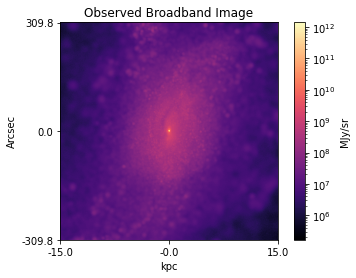

size of pixels at 10pMpc 1.239265424 arcsec 0.059846648424710346 kpc
kpc/arcsec at z 16.463813549981957
size pic in arc at z 0.003635041677496156


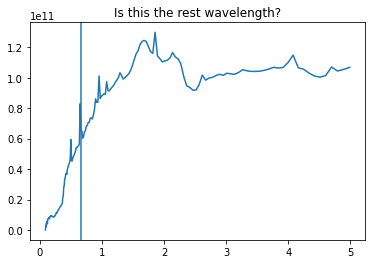

(200, 500, 500) (200,)
this would be the factor you need to brighten by to get intrinsic surface brightness
1.0090586103090236


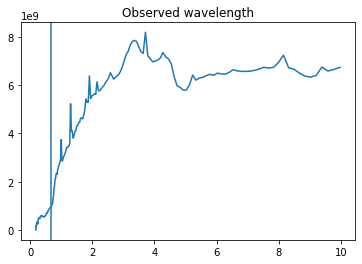

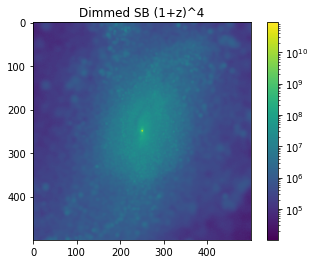

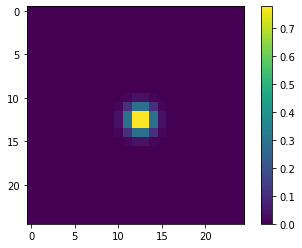

size before rebinning 0.003635041677496156
this will be size after rebinning 0.063


/Users/rebeccanevin/opt/anaconda3/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


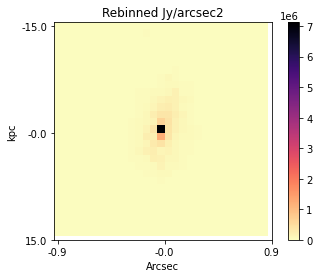

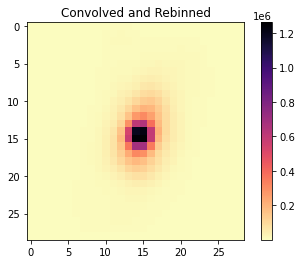

bg limit Jy 4.365422162095828


/Users/rebeccanevin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


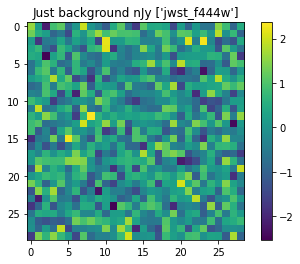

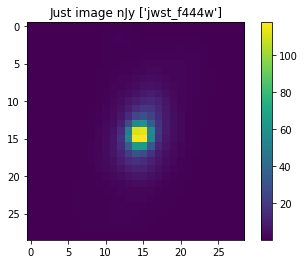

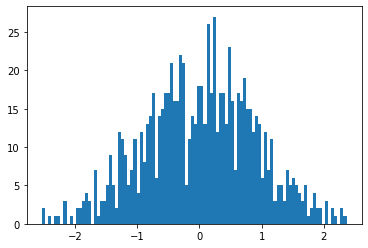

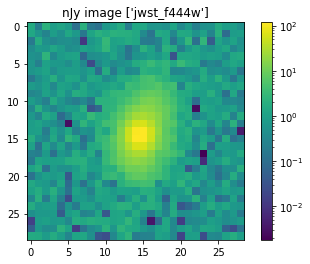

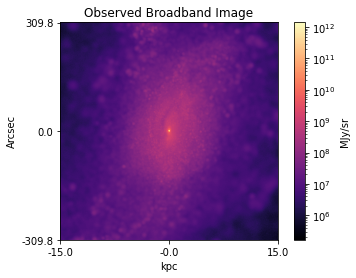

size of pixels at 10pMpc 1.239265424 arcsec 0.059846648424710346 kpc
kpc/arcsec at z 16.463813549981957
size pic in arc at z 0.003635041677496156


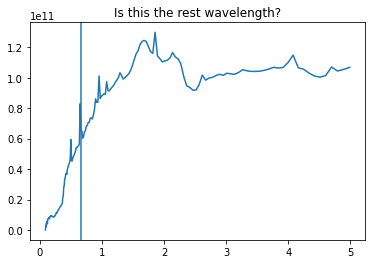

(200, 500, 500) (200,)
this would be the factor you need to brighten by to get intrinsic surface brightness
1.0090586103090236


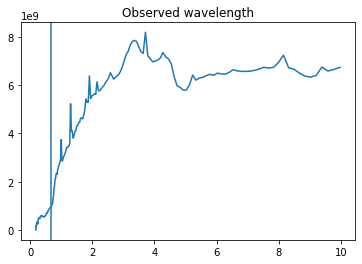

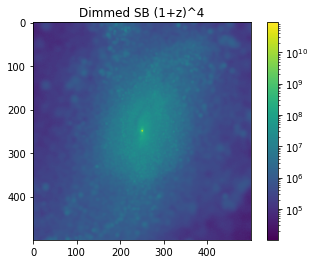

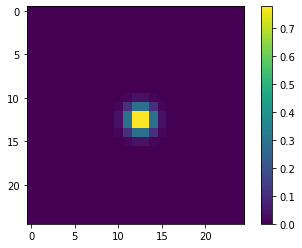

size before rebinning 0.003635041677496156
this will be size after rebinning 0.031


/Users/rebeccanevin/opt/anaconda3/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


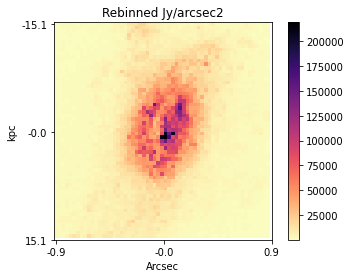

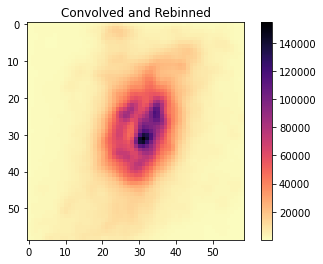

bg limit Jy 2.291006117807585


/Users/rebeccanevin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


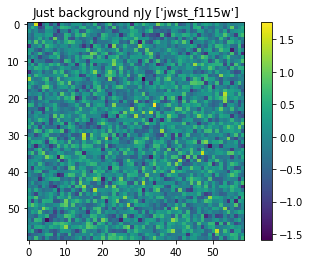

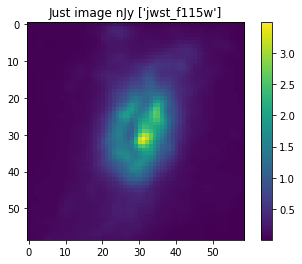

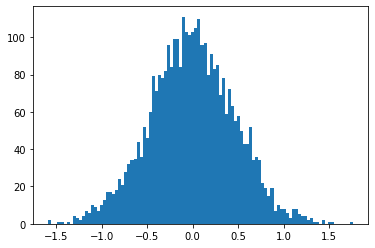

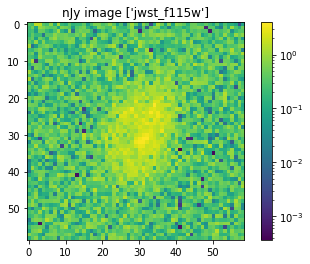

"filter_id = 'F090W'\nsize_detector_pix_arc = 0.031#0.031\nl_eff = 0.9#e4\nbg_limiting_mag = 30.2\nfilter_name = ['jwst_f090w']\nmock_f090w = combine(wav, im5, redshift, cenx, ceny, cut_arc, filter_id, filter_name, \n                     brighten, bg_limiting_mag,\n              size_detector_pix_arc, l_eff, verbose)"

In [ ]:
'''plt.clf()
fig = plt.figure()
ax0 = fig.add_subplot(111)
ax0.contour(np.flipud(mock_f335m), cmap='Blues', nlevels=5)
ax0.contour(np.flipud(mock_f410m), cmap='Reds', nlevels=5)
ax0.set_aspect('equal')
#plt.colorbar()
plt.show()



plt.clf()
fig = plt.figure()
ax0 = fig.add_subplot(111)
ax0.contour(np.flipud(mock_f200w), cmap='Purples', nlevels=5)
#ax0.contour(np.flipud(mock_f150w), cmap='Blues', nlevels=5)
ax0.set_aspect('equal')
#plt.colorbar()
plt.show()

plt.clf()
fig = plt.figure()
ax0 = fig.add_subplot(111)
ax0.contour(np.flipud(mock_f277w), cmap='Reds', nlevels=5)
ax0.contour(np.flipud(mock_f356w), cmap='Blues', nlevels=5)
ax0.set_aspect('equal')
#plt.colorbar()
plt.show()'''




ax3 = fig.add_subplot(144)
im3 = ax3.imshow(mock_1, cmap='magma')#, norm=matplotlib.colors.LogNorm())
ax3.set_title('F444W')
size = np.shape(mock_1)[1]
locs = [0,size/2,size]
size_detector_pix_arc = 0.063
labels = [-round((size/2 - x)*size_detector_pix_arc,1) for x in locs]
ax3.set_xticks([])
ax3.set_yticks([])
plt.colorbar(im3, label='nJy', fraction=0.045)#was erg/s/cm$^2$/AA/arcsec$^2$
#plt.show()
plt.savefig('mock_panels/Galaxy_mock_images_JWST_nJy_redshift_'+str(redshift)+'_'+str(gal)+'.png', dpi=1000)


In [30]:
pixelscale_pc = im5[0].header['CDELT1']
pixelscale_kpc = im5[0].header['CDELT1']/1000

kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift to get the kpc/arcmin scaling                      

print('kpc/arcsec', (kpc_arcmin.value/60))
print('pixelscale kpc', pixelscale_kpc)

size_pix_arc = pixelscale_kpc / (kpc_arcmin.value/60)


size = np.shape(np.sum(im5[0].data, axis=0))[1]


#print(np.shape(mock_3), np.shape(mock_1))

cut_arc = 100#1.5


kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift to get the kpc/arcmin scaling                      
    
size_pix_arc = pixelscale_kpc / (kpc_arcmin.value/60)


size_pix = int(cut_arc/size_pix_arc)


if size_pix > np.shape(im5[0].data)[1]/2: # this would happen if the image isn't big enough
    size_pix = int(np.shape(im5[0].data)[1]/2)
    cut_arc = size_pix*size_pix_arc
# so this is cutting it up to an arcsec size
MJy_cut = im5[0].data[:,cenx-size_pix:cenx+size_pix,ceny-size_pix:ceny+size_pix]
size = np.shape(MJy_cut)[1]

   
    



#STOP
plt.clf()
fig = plt.figure(figsize=(22,10))

ax0 = fig.add_subplot(141)

sim = np.sum(MJy_cut, axis=0)+1e-5

im0 = ax0.imshow(sim, cmap='magma', norm=matplotlib.colors.LogNorm(vmin=1e2, vmax=1e5))
ax0.set_title('Original\nSKIRT Broadband Image')
plt.colorbar(im0, fraction=0.045, label='Bolometric MJy/sr')
size = np.shape(MJy_cut)[1]
print('size of MJy_sr image in arcsec', size*size_pix_arc)
locs = [0,size/2,size]
labels = [-round((size/2 - x)*size_pix_arc,1) for x in locs]
labels_x = [-round((size/2 - x)*size_pix_arc*(kpc_arcmin.value/60),1) for x in locs]
ax0.set_xticks(locs)
ax0.set_xticklabels(labels_x)
ax0.set_xlabel('kpc')
ax0.set_yticks(locs)
ax0.set_yticklabels(labels)
ax0.set_ylabel('Arcsec')

ax1 = fig.add_subplot(142)
im1 = ax1.imshow(mock_f115w, cmap='magma')#, norm=matplotlib.colors.LogNorm())
#ax1.contours(sim, color='white')
ax1.set_title('F115W')
size = np.shape(mock_f115w)[1]

print('size of F115W image in arcsec', size*size_detector_pix_arc)
locs = [0,size/2,size]
size_detector_pix_arc = 0.031
labels = [-round((size/2 - x)*size_detector_pix_arc,1) for x in locs]
ax1.set_xticks(locs)
ax1.set_xticklabels(labels)
ax1.set_xticks([])
ax1.set_yticks([])
plt.colorbar(im1, fraction=0.045)


ax2 = fig.add_subplot(143)
im2 = ax2.imshow(mock_f200w, cmap='magma')#, norm=matplotlib.colors.LogNorm())
ax2.set_title('F200W')
size = np.shape(mock_f200w)[1]
locs = [0,size/2,size]
labels = [-round((size/2 - x)*size_detector_pix_arc,1) for x in locs]
ax2.set_yticks([])
ax2.set_xticks([])
plt.colorbar(im2, fraction=0.045)
#plt.show()

ax3 = fig.add_subplot(144)
im3 = ax3.imshow(mock_f444w, cmap='magma')#, norm=matplotlib.colors.LogNorm())
ax3.set_title('F444W')
size = np.shape(mock_f444w)[1]
locs = [0,size/2,size]
size_detector_pix_arc = 0.063
labels = [-round((size/2 - x)*size_detector_pix_arc,1) for x in locs]
ax3.set_xticks([])
ax3.set_yticks([])
plt.colorbar(im3, label='nJy', fraction=0.045)#was erg/s/cm$^2$/AA/arcsec$^2$
plt.savefig('mock_panels/Galaxy_mock_images_JWST_nJy_redshift_'+str(redshift)+'_'+str(gal)+'.png', dpi=1000)



NameError: name 'im5' is not defined

### Now its time to compare to an actual HST image
This is a good way to make sure the background we derived above makes sense

In [ ]:
#The units of this image are electrons
img = pyfits.open('../Kinematics_SUNRISE/HST_broadband/F814W_drz_sci_rot_crop.fits')
print(img)

image = img[0].data[300:700,300:700]

print(repr(img[0].header))




plt.imshow(image*img[0].header['PHOTFNU'])
plt.colorbar()
plt.show()

print('mean', np.mean(image*img[0].header['PHOTFNU']))
print('std in Jy', np.std(image*img[0].header['PHOTFNU']))


print('multiply by this', img[0].header['PHOTFNU'])

# Put the image in Fnu units (Jy)
Fnu = (image*img[0].header['PHOTFNU'])#/img[0].header['EXPTIME']
Flam = (image*img[0].header['PHOTFLAM'])/0.05**2
print('Fnu', Fnu)


plt.clf()
fig=plt.figure()
ax0 = fig.add_subplot(111)#img[0].header['EXPTIME']
im0 = ax0.imshow(image)
#
plt.colorbar(im0, label='e/s')
#ax0.scatter(img[0].header['CRPIX1'], img[0].header['CRPIX2'])
#40 arcseconds across
#

'''arcsec = 25/2
ax0.set_xticks([img[0].header['OCRPIX1']-(arcsec/(img[0].header['CD1_1']*3600)),img[0].header['OCRPIX1'],img[0].header['OCRPIX1']+(arcsec/(img[0].header['CD1_1']*3600)) ])
ax0.set_xticklabels([arcsec,0,-arcsec])

ax0.set_yticks([img[0].header['OCRPIX2']-(arcsec/(img[0].header['CD2_2']*3600)),img[0].header['OCRPIX2'],img[0].header['OCRPIX2']+(arcsec/(img[0].header['CD2_2']*3600)) ])
ax0.set_yticklabels([-arcsec,0,arcsec])

ax0.set_xlim([img[0].header['OCRPIX1']+(arcsec/(img[0].header['CD1_1']*3600)),img[0].header['OCRPIX1']-(arcsec/(img[0].header['CD1_1']*3600))])
ax0.set_ylim([img[0].header['OCRPIX2']+(arcsec/(img[0].header['CD2_2']*3600)), img[0].header['OCRPIX2']-(arcsec/(img[0].header['CD2_2']*3600))])
'''
plt.show()


plt.clf()
fig=plt.figure()
ax0 = fig.add_subplot(111)#img[0].header['EXPTIME']
im0 = ax0.imshow(Flam)
#
plt.colorbar(im0, label='erg/cm2/s/Ang/arcsec2')
#ax0.scatter(img[0].header['CRPIX1'], img[0].header['CRPIX2'])
#40 arcseconds across
#

'''arcsec = 25/2
ax0.set_xticks([img[0].header['OCRPIX1']-(arcsec/(img[0].header['CD1_1']*3600)),img[0].header['OCRPIX1'],img[0].header['OCRPIX1']+(arcsec/(img[0].header['CD1_1']*3600)) ])
ax0.set_xticklabels([arcsec,0,-arcsec])

ax0.set_yticks([img[0].header['OCRPIX2']-(arcsec/(img[0].header['CD2_2']*3600)),img[0].header['OCRPIX2'],img[0].header['OCRPIX2']+(arcsec/(img[0].header['CD2_2']*3600)) ])
ax0.set_yticklabels([-arcsec,0,arcsec])

ax0.set_xlim([img[0].header['OCRPIX1']+(arcsec/(img[0].header['CD1_1']*3600)),img[0].header['OCRPIX1']-(arcsec/(img[0].header['CD1_1']*3600))])
ax0.set_ylim([img[0].header['OCRPIX2']+(arcsec/(img[0].header['CD2_2']*3600)), img[0].header['OCRPIX2']-(arcsec/(img[0].header['CD2_2']*3600))])
'''
plt.show()


plt.clf()
fig=plt.figure()
ax0 = fig.add_subplot(111)#img[0].header['EXPTIME']
im0 = ax0.imshow(Fnu*1e9, norm=matplotlib.colors.LogNorm())
#
plt.colorbar(im0, label='nJy')
#ax0.scatter(img[0].header['CRPIX1'], img[0].header['CRPIX2'])
#40 arcseconds across
#


plt.show()




# Optionally then convert from Fnu units into AB mag units by finding the zeropoint
ABMAG_ZPT = -2.5*np.log10(img[0].header['PHOTFLAM']) - 21.10 - 5*np.log10(img[0].header['PHOTPLAM']) + 18.692
ABMAG = -2.5*np.log10(Fnu) - ABMAG_ZPT#48.6





# Aimee has a better way of doing this that looks only at the background-dominated regions


hist_data = np.ma.masked_where(Fnu==0., Fnu).flatten()

plt.clf()
hist1 = plt.hist(hist_data, bins=100)
#plt.xlim([-1,1])
plt.yscale('log', nonposy='clip')
plt.ylabel('#')
plt.xlabel('Janskies')
#plt.xlim([-100,100])
plt.show()

#print(hist1)

# These should be the image statistics in Jy
print(np.mean(hist_data),np.std(hist_data))


# what about if you only take the BG?
hist_data = Fnu[0:50,0:50].flatten()

plt.clf()
hist1 = plt.hist(hist_data, bins=100)
#plt.xlim([-1,1])
#plt.yscale('log', nonposy='clip')
plt.ylabel('#')
plt.xlabel('Janskies')
#plt.xlim([-100,100])
plt.show()

#print(hist1)

# These should be the image statistics in Jy
print(np.mean(hist_data),np.std(hist_data))


hist_data = Flam[0:50,0:50].flatten()

plt.clf()
hist1 = plt.hist(hist_data, bins=100)
#plt.xlim([-1,1])
#plt.yscale('log', nonposy='clip')
plt.ylabel('#')
plt.xlabel('erg/cm2/Ang/s/arcsec2')
#plt.xlim([-100,100])
plt.show()

#print(hist1)

# These should be the image statistics in Jy
print(np.mean(hist_data),np.std(hist_data))


In [ ]:
### Show them side by side

In [ ]:
#final_mag_z_2 = final_mags
#final_mag_z_half = final_mags
#final_mag_z_same = final_mags
final_mag_z_1 = final_mags
fig = plt.figure(figsize = (10,7))

ax0 = fig.add_subplot(141)
im0 = ax0.imshow(final_mag_z_same, cmap='magma_r')#, vmin=20,vmax=26)#, vmin=24, vmax=28)
plt.colorbar(im0, fraction=0.045)
ax0.set_title('$z = 0.34$')
ax0.set_xlabel('WFC3 F814W')

locs = [0,size/2,size]
labels = [round((size/2 - x)*0.04,1) for x in locs]
ax0.set_xticks(locs)
ax0.set_xticklabels(labels)
ax0.set_yticks(locs)
ax0.set_yticklabels(labels)
ax0.set_ylabel('Arcsec')

ax1 = fig.add_subplot(142)
im1 = ax1.imshow(final_mag_z_1, cmap='magma_r')#, vmin=24, vmax=28)
plt.colorbar(im1, fraction=0.045)
ax1.set_title('$z = 1$')
ax1.set_xlabel('WFC3 F105W')

ax1.set_xticks(locs)
ax1.set_xticklabels(labels)
ax1.set_yticks(locs)
ax1.set_yticklabels(labels)


ax3 = fig.add_subplot(143)
im3 = ax3.imshow(final_mag_z_2, cmap='magma_r')#, vmin=24, vmax=28)
plt.colorbar(im3, fraction=0.045)
ax3.set_title('$z = 2$')
ax3.set_xlabel('WFC3 F814W')
ax3.set_xticks(locs)
ax3.set_xticklabels(labels)
ax3.set_yticks(locs)
ax3.set_yticklabels(labels)

ax4 = fig.add_subplot(144)
im4 = ax4.imshow(m, cmap='magma_r', vmin=23, vmax=50)#, vmin=20,vmax=26)#, vmin=0, vmax=27)
arcsec = 25/2
ax4.set_xticks([img[0].header['OCRPIX1']-(arcsec/(img[0].header['CD1_1']*3600)),img[0].header['OCRPIX1'],img[0].header['OCRPIX1']+(arcsec/(img[0].header['CD1_1']*3600)) ])
ax4.set_xticklabels([arcsec,0,-arcsec])

ax4.set_yticks([img[0].header['OCRPIX2']-(arcsec/(img[0].header['CD2_2']*3600)),img[0].header['OCRPIX2'],img[0].header['OCRPIX2']+(arcsec/(img[0].header['CD2_2']*3600)) ])
ax4.set_yticklabels([-arcsec,0,arcsec])

ax4.set_xlim([img[0].header['OCRPIX1']+(arcsec/(img[0].header['CD1_1']*3600)),img[0].header['OCRPIX1']-(arcsec/(img[0].header['CD1_1']*3600))])
ax4.set_ylim([img[0].header['OCRPIX2']+(arcsec/(img[0].header['CD2_2']*3600)), img[0].header['OCRPIX2']-(arcsec/(img[0].header['CD2_2']*3600))])
plt.colorbar(im4, fraction=0.045)
ax4.set_title('$z = 0.34$')
ax4.set_xlabel('Real Image\nACS F814W')

plt.subplots_adjust(hspace=0.5, wspace=0.7)

plt.savefig('ADAP.png', dpi=500)

In [ ]:
print(np.shape(im5[0].data), np.shape(wav))
SKIRT_spec = np.sum(im5[0].data, axis=(1,2))
plt.clf()
plt.plot(wav[1:]*10**4, SKIRT_spec*wav[1:])
#plt.xlim([0.4,0.6])
plt.xlim([4000,6000])
plt.ylim([0,5e5])
plt.show()

NameError: name 'SKIRT_spec' is not defined

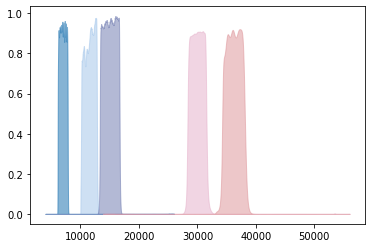

In [73]:


# Try to get individual filter curves
F070W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F070W_filteronly_ModAB_mean.txt',
                  skiprows=1)
F115W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F115W_filteronly_ModAB_mean.txt',
                  skiprows=1)
F140M = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F140M_filteronly_ModAB_mean.txt',
                  skiprows=1)
F150W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F150W_filteronly_ModAB_mean.txt',
                  skiprows=1)
F150W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F150W_filteronly_ModAB_mean.txt',
                  skiprows=1)
F300M = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F300M_filteronly_ModAB_mean.txt',
                  skiprows=1)
F360M = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F360M_filteronly_ModAB_mean.txt',
                  skiprows=1)
F480M = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F480M_filteronly_ModAB_mean.txt',
                  skiprows=1)


#format is microns and throughput
plt.fill_between(F070W[:,0]*10**4, 0, F070W[:,1], label='F070W', color='#0D69AB', alpha=0.5)

plt.fill_between(F115W[:,0]*10**4, 0, F115W[:,1], label='F115W', color='#9FC3E9', alpha=0.5)
plt.fill_between(F150W[:,0]*10**4, 0, F150W[:,1], label='F150W', color='#6874AC', alpha=0.5)
plt.fill_between(F300M[:,0]*10**4, 0, F300M[:,1], label='F300M',color='#E4ADC8', alpha=0.5)
plt.fill_between(F360M[:,0]*10**4, 0, F360M[:,1], label='F360M',color='#DC9095', alpha=0.5)

plt.plot(wav[1:]*10**4*(1+redshift), SKIRT_spec/1e6)
#plt.xlim([0,2])
plt.ylim([0,1])
plt.xlim([0,100000])
plt.legend()
plt.xlabel(r'$\AA$')
plt.ylabel('Summed MJy/sr')
plt.show()

# Okay how do I select?
#np.convolve(SKIRT_spec)
from scipy import interpolate, fftpack



(234, 500, 500)


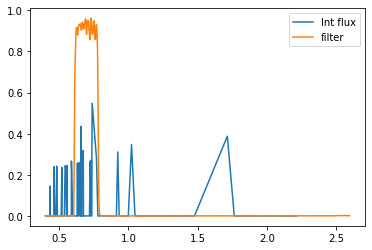

0.40078326999999997 0.39914999389648437
(160,) (160,) (160,) (2201,) (2201,)


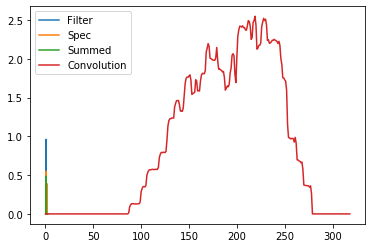

NameError: name 'STOP' is not defined

In [20]:
# Now how to translate this into an image?
# Oh ****, gotta do a multiplication in 3D 


# Check out Xuejian's code - https://bitbucket.org/ShenXuejian/dust-modeling/src/master/modelC/TUNE/tune_getapmag.py
# Also: https://github.com/gbrammer/sedpy/blob/master/sedpy/observate.py
# Also the SVO filter curves: http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=JWST

def get_broadband(wav, cube, filter_jwst):
    # Input the cube and wavelength, cut into the area for each filter, 
    # and output the broadband image summed over those wavelengths
    print(np.shape(cube))
    broadband_img = np.zeros((np.shape(cube)[1], np.shape(cube)[2]))
    
    for i in range(np.shape(cube)[1]):
        for j in range(np.shape(cube)[2]):
            spec = cube[:,i,j]
            #SKIRT_spec = np.sum(im5[0].data, axis=(1,2))

            cut_index0 = find_nearest(wav,filter_jwst[:,0][0])[1]
            cut_index1 = find_nearest(wav,filter_jwst[:,0][-1])[1]
            int_func = interpolate.interp1d(filter_jwst[:,0],filter_jwst[:,1])#wav[1:], SKIRT_spec)
            plt.clf()
            plt.plot(wav[cut_index0:cut_index1], 
                                            spec[cut_index0:cut_index1], label='Int flux')
            plt.plot(filter_jwst[:,0],filter_jwst[:,1], label='filter')
            #plt.plot(wav[cut_index0:cut_index1],spec[cut_index0:cut_index1],label='OG spec')
            #plt.plot(wav[cut_index0:cut_index1],int_flux, label='Filter')
            plt.legend()
            plt.show()
            try:
                print(wav[cut_index0], filter_jwst[:,0][0])
                int_flux = int_func(wav[cut_index0:cut_index1])
                broadband_img[i,j] = np.sum(int_flux*spec[cut_index0:cut_index1])
                conv = np.convolve(int_flux,spec[cut_index0:cut_index1])
                print(np.shape(wav[cut_index0:cut_index1]), np.shape(spec[cut_index0:cut_index1]),
                     np.shape(int_flux), np.shape(filter_jwst[:,1]), np.shape(filter_jwst[:,0]))
                plt.clf()
                plt.plot(wav[cut_index0:cut_index1],int_flux, label='Filter')
                plt.plot(wav[cut_index0:cut_index1],spec[cut_index0:cut_index1], label='Spec')
                plt.plot(wav[cut_index0:cut_index1], int_flux*spec[cut_index0:cut_index1], label='Summed')
                plt.plot( conv, label='Convolution')
                #plt.plot(wav[cut_index0:cut_index1],spec[cut_index0:cut_index1],label='OG spec')
                #plt.plot(wav[cut_index0:cut_index1],int_flux, label='Filter')
                plt.legend()
                plt.show()
                
                
                STOP
            except:
                STOP
                
                
                nonzero = np.where(filter_jwst[:,1] > 0.01)
                nonzero_filter = filter_jwst[:,1][nonzero]
                nonzero_filter_x = filter_jwst[:,0][nonzero]
                
                
                
                if nonzero_filter_x[-1] > wav[-1]:
                    print('Filter not covered')
                    print('final wavelength of the filter', nonzero_filter_x[-1], 'final wav', wav[-1])
                    
                    plt.clf()
                    plt.plot(nonzero_filter_x, nonzero_filter)
                    plt.show()
                    
                    STOP
                    return broadband_img
                
                else:
                    int_flux = int_func(nonzero_filter_x)
                    broadband_img[i,j] = np.sum(nonzero_filter*int_flux)
                    plt.plot(no)
                    #mayebs show the difference betwen convolution and just summing the multiplication first?
                    
                    STOP
            
            '''plt.clf()
            plt.plot(filter_jwst[:,0], filter_jwst[:,1]*int_flux, label='Interpolated Fluxes')
            plt.fill_between(filter_jwst[:,0], 0, filter_jwst[:,1], label='F150W', color='#6874AC', alpha=0.5)

            plt.legend()
            #plt.xlim([1.2,1.6])
            plt.show()'''
    return broadband_img
F070W_img = get_broadband(wav[1:], im5[0].data, F070W)
F115W_img = get_broadband(wav[1:], im5[0].data, F115W)
F150W_img = get_broadband(wav[1:], im5[0].data, F150W)
F300M_img = get_broadband(wav[1:], im5[0].data, F300M)
F360M_img = get_broadband(wav[1:], im5[0].data, F360M)



(500, 500)
Text(0, 0, '') [-100.    0.  100.  200.  300.  400.  500.]


<Figure size 432x288 with 0 Axes>

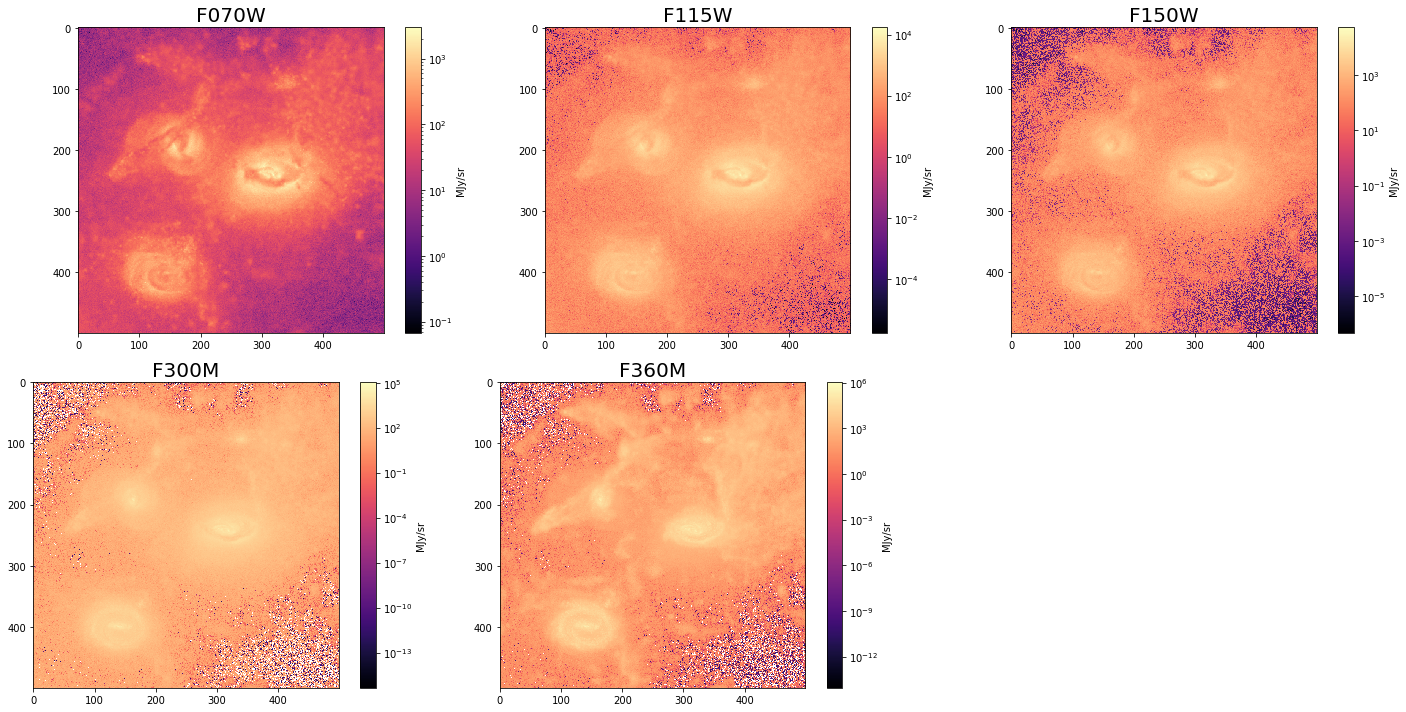

In [17]:
## Now you can make a beautiful image for all the different broadband filters :)
print(np.shape(F115W_img))

universal_cmap = 'magma'

plt.clf()
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(231)
im0 = ax0.imshow(F070W_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im0, label = 'MJy/sr', fraction = 0.046)
ax0.set_title('F070W', size=20)

ax1 = fig.add_subplot(232)
im1 = ax1.imshow(F115W_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im1, label = 'MJy/sr', fraction = 0.046)
ax1.set_title('F115W', size=20)

ax2 = fig.add_subplot(233)
im2 = ax2.imshow(F150W_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im2, label = 'MJy/sr', fraction = 0.046)
ax2.set_title('F150W', size=20)

ax3 = fig.add_subplot(234)
im3 = ax3.imshow(F300M_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im3, label = 'MJy/sr')
ax3.set_title('F300M', size=20)

ax4 = fig.add_subplot(235)
im4 = ax4.imshow(F360M_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im4, label = 'MJy/sr')
ax4.set_title('F360M', size=20)

locs, labels = plt.xticks()
print(labels[1], locs)
#plt.xticklabels()
plt.tight_layout()
plt.show()
#45 kpc per side



### Uh oh gotta get in the right units?
This page in converting to AB mags is useful: https://en.wikipedia.org/wiki/AB_magnitude



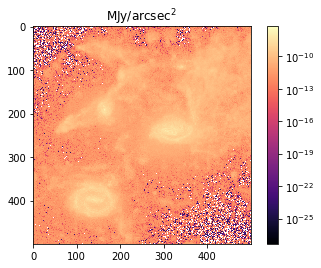

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


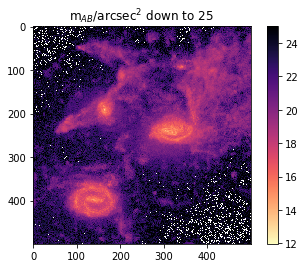

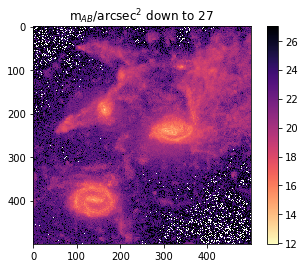

In [16]:
# First, convert to per arcsec^2 
cube_per_arc = F360M_img/4.25e10

plt.clf()
plt.imshow(cube_per_arc, norm = matplotlib.colors.LogNorm(), cmap = 'magma')
plt.title('MJy/arcsec$^2$')
plt.colorbar()
plt.show()

#{\displaystyle m_{\text{AB}}=-2.5\log _{10}f_{\nu }+8.90.}
# So now convert to AB mags (m_AB):
import math
m_AB = -2.5*np.log10(np.array(cube_per_arc)*10**6)+8.9

plt.clf()
plt.imshow(m_AB, cmap = 'magma_r', vmax=25)# norm = matplotlib.colors.LogNorm(),
plt.title('m$_{AB}$/arcsec$^2$ down to 25')
plt.colorbar()
plt.show()
plt.clf()
plt.imshow(m_AB, cmap = 'magma_r', vmax=27)# norm = matplotlib.colors.LogNorm(),
plt.title('m$_{AB}$/arcsec$^2$ down to 27')
plt.colorbar()
plt.show()



### The next step is to duplicate the PSF from the telescope
And the key is to keep the pixels of the generated PSF the same size as the 0.1" pixels of the image.
This is an useful reference: https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-point-spread-functions#NIRCamPointSpreadFunctions-SimulatedNIRCamPSFs

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps
Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps
Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps
Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 9 steps
Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 9 steps


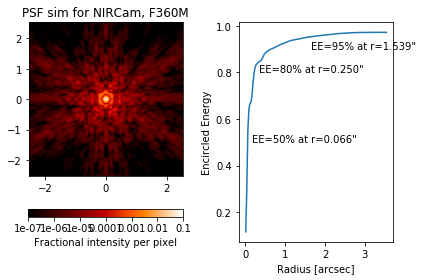

In [13]:
# First set the environmental variable
import os
os.environ['WEBBPSF_PATH'] = '/Users/beckynevin/CfA_Code/illustris_python/webbpsf-data'
import webbpsf

nircam = webbpsf.NIRCam()
nircam.pixelscale = size_pix_arc#0.0314159
nircam.filter = 'F070W'#'F210M'
psf070 = nircam.calc_psf(oversample=2)
nircam.filter = 'F115W'#'F210M'
psf115 = nircam.calc_psf(oversample=2)
nircam.filter = 'F150W'#'F210M'
psf150 = nircam.calc_psf(oversample=2)
nircam.filter = 'F300M'#'F210M'
psf300 = nircam.calc_psf(oversample=2)

nircam = webbpsf.NIRCam()
nircam.pixelscale = size_pix_arc#0.0314159
nircam.filter = 'F360M'#'F210M'
psf360 = nircam.calc_psf()


# display the PSF and plot the encircled energy
plt.subplot(1,2,1)
webbpsf.display_psf(psf360, colorbar_orientation='horizontal')
axis2 = plt.subplot(1,2,2)
webbpsf.display_ee(psf360, ax=axis2)

#psf210.writeto('nircam_F210M.fits')
plt.tight_layout()
plt.savefig('plot_nircam_f360M.pdf', overwrite=True)

### Maybe make a 1D plot of this?

0.10524250748966657 pixelscale in arcsec/pix 0.10524250748966657 pixelscale of image


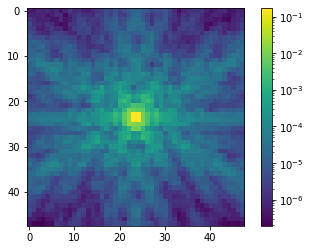

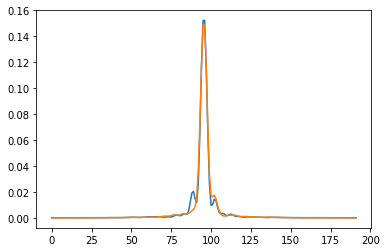

In [14]:
#print(np.shape(psf210[0].data))
#print(psf360[0].header)
print(psf360[1].header['PIXELSCL'], 'pixelscale in arcsec/pix', size_pix_arc, 'pixelscale of image')
plt.clf()
plt.imshow(psf360[1].data, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

plt.plot(np.sum(psf360[0].data,axis=0))
plt.plot(np.sum(psf360[0].data,axis=1))
plt.show()


### Try convolving

In [15]:
from scipy import signal
grad = signal.convolve2d(F360M_img, psf360[1].data, boundary='symm', mode='same')

<Figure size 432x288 with 0 Axes>

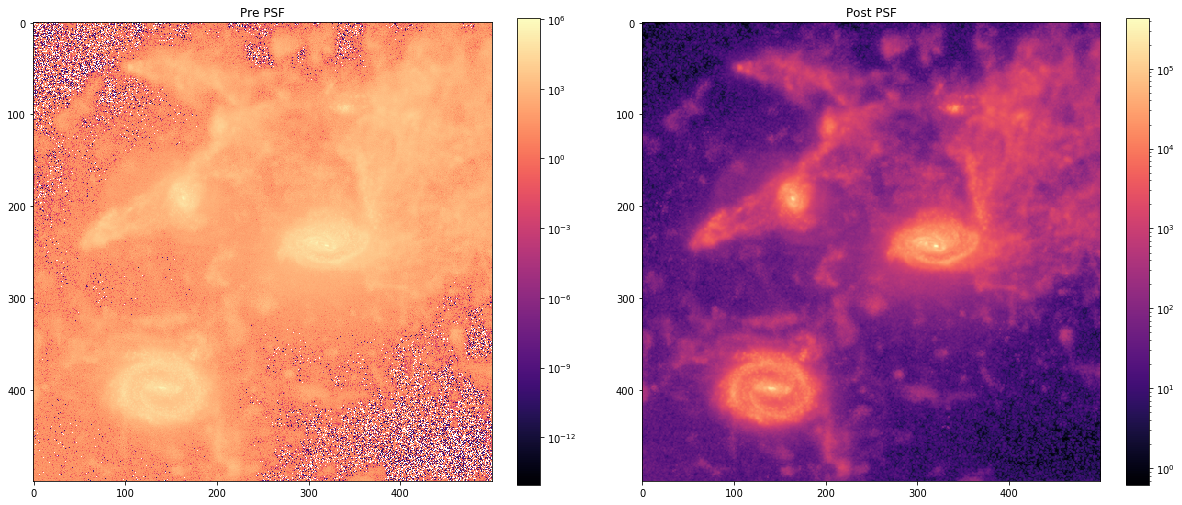

In [16]:
plt.clf()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.set_title('Pre PSF')
im1 = ax1.imshow(F360M_img, cmap='magma', norm=matplotlib.colors.LogNorm())
plt.colorbar(im1, fraction=0.046)

ax2 = fig.add_subplot(122)

im2 = ax2.imshow(grad, cmap='magma', norm=matplotlib.colors.LogNorm())
plt.colorbar(im2, fraction=0.046)
ax2.set_title('Post PSF')
plt.show()

### Rebinning
eight for 0.6–2.3 µm observations (0.031"/pixel) and two for 2.4–5.0 µm (0.063"/pixel)
so actually the image is lower res than JWST 

factor 1.6705159918994694


<Figure size 432x288 with 0 Axes>

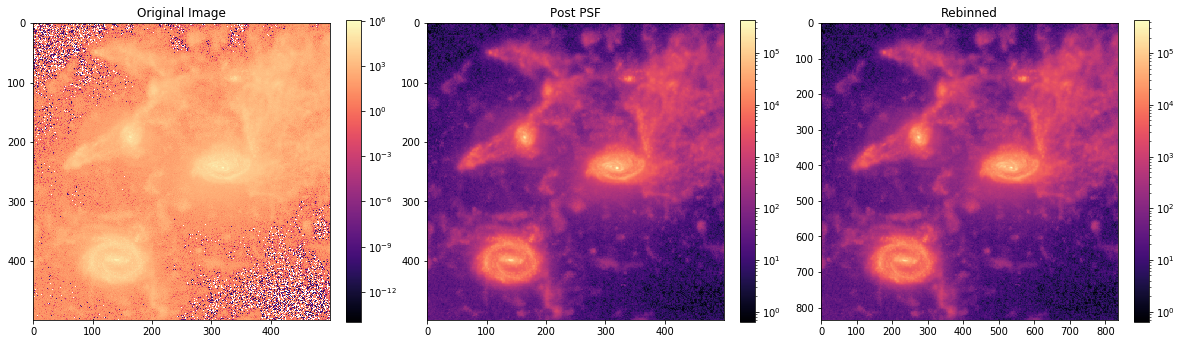

In [18]:
import scipy
factor = size_pix_arc/0.063
print('factor', factor)
rebin = scipy.ndimage.zoom(grad, factor, order=0)


plt.clf()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(131)
ax1.set_title('Original Image')
im1 = ax1.imshow(F360M_img, cmap='magma', norm=matplotlib.colors.LogNorm())
plt.colorbar(im1, fraction=0.046)

ax2 = fig.add_subplot(132)

im2 = ax2.imshow(grad, cmap='magma', norm=matplotlib.colors.LogNorm())
plt.colorbar(im2, fraction=0.046)
ax2.set_title('Post PSF')

ax3 = fig.add_subplot(133)

im3 = ax3.imshow(rebin, cmap='magma', norm=matplotlib.colors.LogNorm())
ax3.set_title('Rebinned')
plt.colorbar(im3, fraction=0.046)
plt.show()

### Noise
This is going to be a little bit trickier


### Background
The background sky can be a good source of extra photons, but apparently it really varies as a function of time of year and exposure time: https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-imaging-sensitivity

### From Snyder et al. 2019:
We convolve each image with an appropriate point- spread function (PSF) modeled with the TinyTim (Krist et al. 2011) and WebbPSF (Perrin et al. 2014) tools as ap- propriate. The resulting data product is then ready to mod- ify as appropriate for any desired effective exposure time. For our purposes, we create two sets of images with noise added, SB25 and SB27, using a procedure to ensure unifor- mity across filters and instruments. We add normally dis- tributed random sky shot noise to each pixel such that the fi- nal images achieve a 5σ limiting surface brightness of 25 and 27 magnitudes per square arcsecond, respectively.

### Here's a page for background rates in mJy/sr:
https://jwst-docs.stsci.edu/jwst-observatory-functionality/jwst-background-model

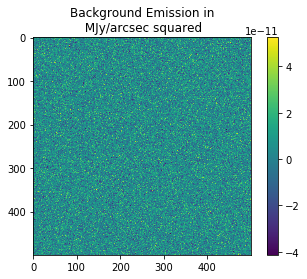

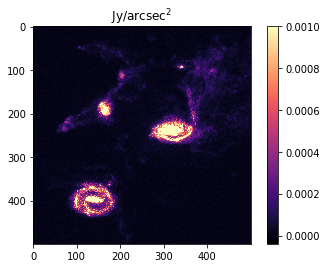

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log10


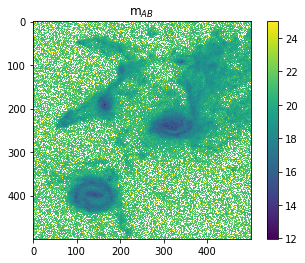

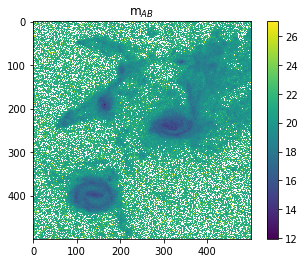

In [29]:
#@3.5 microns, the sky background is 2e-1 MJy/sr, this really seems negligible relative to what we have here
import numpy as np
import matplotlib.pyplot as plt
background = np.zeros((500,500))
mu, sigma = 2e-1, np.sqrt(2e-1) # mean and standard deviation

for i in range(np.shape(background)[0]):
    for j in range(np.shape(background)[1]):
        s = np.random.normal(mu, sigma, 1)
        background[i,j] = s

        
plt.clf()
plt.imshow(background/4.25e10)
plt.colorbar()
plt.title('Background Emission in\n MJy/arcsec squared')
plt.show()


plt.clf()
plt.imshow(10**6*(cube_per_arc+background/4.25e10), cmap = 'magma', vmax=0.001)# norm = matplotlib.colors.LogNorm(),
plt.title('Jy/arcsec$^2$')
plt.colorbar()
plt.show()

img_bg = 10**6*(cube_per_arc+background/4.25e10)

m_AB = -2.5*np.log10(img_bg)+8.9

plt.clf()
plt.imshow(m_AB, vmax=25)
plt.colorbar()
plt.title('m$_{AB}$')
plt.show()

plt.clf()
plt.imshow(m_AB, vmax=27)
plt.colorbar()
plt.title('m$_{AB}$')
plt.show()


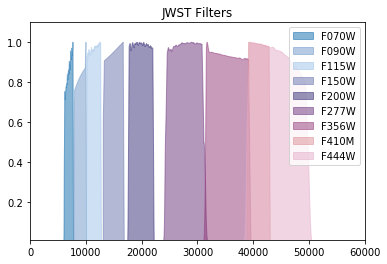

In [44]:
# So these are all Greg's filters:
# Which seem to be rougher than the official ones

F070W_g = np.loadtxt('greg_JWST_filters/nircam_f070w')
F090W_g = np.loadtxt('greg_JWST_filters/nircam_f090w')
F115W_g = np.loadtxt('greg_JWST_filters/nircam_f115w')
F150W_g = np.loadtxt('greg_JWST_filters/nircam_f150w')
F200W_g = np.loadtxt('greg_JWST_filters/nircam_f200w')
F277W_g = np.loadtxt('greg_JWST_filters/nircam_f277w')
F356W_g = np.loadtxt('greg_JWST_filters/nircam_f356w')
F444W_g = np.loadtxt('greg_JWST_filters/nircam_f444w')
F410M_g = np.loadtxt('greg_JWST_filters/nircam_F410M')


plt.clf()
plt.fill_between(F070W_g[:,0], 0, F070W_g[:,1], label='F070W', color='#0D69AB', alpha=0.5)
plt.fill_between(F090W_g[:,0], 0, F090W_g[:,1], label='F090W', color='#6E99C9', alpha=0.5)
plt.fill_between(F115W_g[:,0], 0, F115W_g[:,1], label='F115W', color='#9FC3E9', alpha=0.5)

plt.fill_between(F150W_g[:,0], 0, F150W_g[:,1], label='F150W', color='#6874AC', alpha=0.5)
plt.fill_between(F200W_g[:,0], 0, F200W_g[:,1], label='F200W', color='#342B75', alpha=0.5)

plt.fill_between(F277W_g[:,0], 0, F277W_g[:,1], label='F277W', color='#6B327B', alpha=0.5)
plt.fill_between(F356W_g[:,0], 0, F356W_g[:,1], label='F356W', color='#923978', alpha=0.5)

plt.fill_between(F410M_g[:,0], 0, F410M_g[:,1], color='#DC9095', alpha=0.5, label='F410M')

plt.fill_between(F444W_g[:,0], 0, F444W_g[:,1], label='F444W', color='#E4ADC8', alpha=0.5)


#plt.plot(F410M_g[:,0], F410M_g[:,1], label='F410M', color='#DC9095')


plt.xlim([0,60000])
plt.ylim([0.01,1.1])
plt.title(r'JWST Filters')
plt.legend()
plt.show()

In [63]:
# Try to get filter curves up and running:
#! /usr/bin/env/ python

'''plot the components of the optics file...for the TR'''

from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np

def replace_nan(items):
    for index, item in enumerate(items):
        if (item == '---'):
            items[index] = float('nan')
    return items


ofile = 'nircam_throughputs/optics/NIRCam_optics_transmission_29Oct2015.csv'

opttab = ascii.read(ofile,header_start=1,data_start=2,format='csv')


wave = opttab['Wavelength'].data.data
nvr_thru = opttab['NVR_Transmission'].data.data
nvr_wave = opttab['NVR_Wavelength'].data.data
collimator = opttab['Collimator'].data.data
sw_triplet = replace_nan(opttab['SW_Triplet'].data.data).astype('float')
sw_mirrors = replace_nan(opttab['SW_Mirrors'].data.data).astype('float')
lw_triplet = replace_nan(opttab['LW_triplet'].data.data).astype('float')
lw_mirrors = replace_nan(opttab['LW_Mirrors'].data.data).astype('float')
sw_particulates = replace_nan(opttab['SW_Particulates'].data.data).astype('float')
lw_particulates = replace_nan(opttab['LW_Particulates'].data.data).astype('float')

#remove extra entries in NVR columns
good = np.where(nvr_wave != 0.)[0]
nvr_thru = nvr_thru[good]
nvr_wave = nvr_wave[good]


#interpolate NVR to the same wavelength scale as the other columns
nvr_interp = np.interp(wave,nvr_wave,nvr_thru)

#combine the elements to produce a SW optics curve and a LW optics curve
#The 0.98 factor is a 'contingency factor' John Stansberry included in a 
#previous version. He said we can keep it out for this version
sw_optics = collimator * sw_triplet * sw_mirrors * sw_particulates #* 0.98
lw_optics = collimator * lw_triplet * lw_mirrors * lw_particulates #* 0.98


f,a = plt.subplots()
a.plot(wave,collimator,color='red',label='Collimator')

a.plot(wave,sw_triplet,color='blue',label='SW Triplet')
a.plot(wave,sw_mirrors,color='black',label='SW Mirrors')
a.plot(wave,sw_particulates,color='green',label='SW Particulates')

a.plot(wave,lw_triplet,color='blue',linestyle='--',label='LW Triplet')
a.plot(wave,lw_mirrors,color='black',linestyle='--',label='LW Mirrors')
a.plot(wave,lw_particulates,color='green',linestyle='--',label='LW Particulates')

a.plot(nvr_wave,nvr_thru,color='orange',label='NVR')

a.plot(wave,sw_optics,color='magenta',label='Total SW')
a.plot(wave,lw_optics,color='magenta',linestyle='--',label='Total LW')

a.set_xlim(0.5,5.5)
a.set_ylabel('Throughput')
a.set_xlabel('Wavelength (microns)')
a.legend(loc='lower right')

f.savefig('Optics_components_plot.pdf')
plt.close(f)
